# Baseline model based on anatomy features

Useful links :

- https://brainder.org/2018/01/23/how-do-we-measure-thickness-area-and-volume-of-the-cerebral-cortex/
- https://s3.us-east-2.amazonaws.com/brainder/publications/2010/winkler2010_thickness_area.pdf
    - The results suggest that surface area and cortical thickness measurements should be considered separately and preferred over gray matter volumes for imaging genetic studies.

In [1]:
path = ".."

import sys
sys.path.insert(0, path)

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

In [3]:
from problem import get_train_data, get_test_data

data_train_, labels_train_ = get_train_data(path=path)
data_test_, labels_test_ = get_test_data(path=path)

In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit


def evaluation(X, y, verbose=False):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.65, random_state=42).split(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=verbose, return_train_score=True,
                             n_jobs=1)
    
    return results


from problem import get_cv


def original_evaluation(X, y, verbose):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = get_cv(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=verbose, return_train_score=True,
                             n_jobs=1)    
    return results

## Preprocess input data

Join train and test

In [5]:
data_train = pd.concat([data_train_, pd.Series(labels_train_, index=data_train_.index, name='target')], axis=1)
data_test = pd.concat([data_test_, pd.Series(labels_test_, index=data_test_.index, name='target')], axis=1)

data_train.loc[:, 'is_train'] = 1
data_test.loc[:, 'is_train'] = 0

data = pd.concat([data_train, data_test], axis=0)
is_train = data['is_train'] == 1

In [6]:
data['participants_sex'] = data['participants_sex'].map({'F': -1.0, 'M': +1.0}) 
accepted_anatomy = data['anatomy_select'].isin([1, 2])

In [7]:
data.shape

(1150, 223)

In [8]:
data.loc[:, 'index'] = np.arange(len(data))

Remove poor QA data

In [9]:
data1 = data[accepted_anatomy].copy()
data1.shape

(1031, 224)

In [10]:
import re 

left_cols = sorted([col for col in data1.columns if col.startswith('anatomy') and re.match(r".+(lh|Left)", col)])

left_cols.remove('anatomy_Left-WM-hypointensities')
left_cols.remove('anatomy_Left-non-WM-hypointensities')

right_cols = []
for c in left_cols:
    if "lh" in c:
        c = c.replace("lh", "rh")
    elif "Left" in c:
        c = c.replace("Left", "Right")
    right_cols.append(c)

anatomy_LR_diff_cols = [(c1, c2) for c1, c2 in zip(left_cols, right_cols)]
anatomy_LR_sum_cols = [(c1, c2) for c1, c2 in zip(left_cols, right_cols)]

In [11]:
to_remove_anatomy_features = [
    'anatomy_Left-WM-hypointensities',
    'anatomy_Left-non-WM-hypointensities',
    'anatomy_Right-WM-hypointensities',
    'anatomy_Right-non-WM-hypointensities',
    'anatomy_5th-Ventricle', 
    'anatomy_non-WM-hypointensities',
    
    # is L + R   
    'anatomy_CortexVol',
    'anatomy_SurfaceHoles',
    'anatomy_CerebralWhiteMatterVol',
    
    # Correlated with others
    'anatomy_EstimatedTotalIntraCranialVol',
    'anatomy_SupraTentorialVolNotVentVox',
]

In [12]:
anatomy_cols = [col for col in data1.columns if col.startswith('anatomy')]

anatomy_cols.remove('anatomy_select')

for c in to_remove_anatomy_features:
    anatomy_cols.remove(c)

participant_cols = [col for col in data1.columns if col.startswith('participant')]
participant_cols.remove('participants_site')

In [13]:
len(anatomy_cols)

196

In [14]:
anatomy_diff_cols = []
anatomy_sum_cols = []
to_remove_anatomy_diff_cols = []


for c1, c2 in anatomy_LR_diff_cols:
    data1.loc[:, "({} - {})".format(c1, c2)] = data1[c1] - data1[c2]
    anatomy_diff_cols.append("({} - {})".format(c1, c2))
    to_remove_anatomy_diff_cols.append(c1)
    to_remove_anatomy_diff_cols.append(c2)    

    
for c1, c2 in anatomy_LR_sum_cols:
    data1.loc[:, "({} + {})".format(c1, c2)] = (data1[c1] + data1[c2]) * 0.5
    anatomy_sum_cols.append("({} + {})".format(c1, c2))
    

for c in to_remove_anatomy_diff_cols:
    anatomy_cols.remove(c)    

In [15]:
len(anatomy_diff_cols), len(anatomy_sum_cols)

(87, 87)

In [16]:
data1.shape

(1031, 398)

In [17]:
data1.loc[:, anatomy_cols].head()

anatomy_3rd-Ventricle  anatomy_4th-Ventricle  \
subject_id                                                           
1932355398536124106                   704.9                 1643.0   
5174041730092253771                  1045.9                 2122.7   
10219322676643534800                  929.1                 2398.6   
10645466564919190227                  613.0                 1962.5   
14512541342641936232                  549.3                 1477.1   

                      anatomy_Brain-Stem  anatomy_CSF  \
subject_id                                              
1932355398536124106              18193.3        736.1   
5174041730092253771              23983.3       1065.3   
10219322676643534800             20630.9        861.4   
10645466564919190227             17555.6        602.3   
14512541342641936232             22295.6        751.4   

                      anatomy_WM-hypointensities  anatomy_Optic-Chiasm  \
subject_id                                                               
1932355398536124106                        532.4                 263.7   
5174041730092253771                        696.8                 163.0   
10219322676643534800                       722.2                 205.0   
10645466564919190227                      1447.7                 170.1   
14512541342641936232                       769.5                 162.8   

                      anatomy_CC_Posterior  anatomy_CC_Mid_Posterior  \
subject_id                                                             
1932355398536124106                  757.6                     462.6   
5174041730092253771                  902.0                     603.0   
10219322676643534800                 885.8                     540.0   
10645466564919190227                 692.2                     566.3   
14512541342641936232                1119.3                     598.0   

                      anatomy_CC_Central  anatomy_CC_Mid_Anterior  \
subject_id                                                          
1932355398536124106                446.1                    400.8   
5174041730092253771                527.4                    507.9   
10219322676643534800               763.9                    808.7   
10645466564919190227               557.2                    451.3   
14512541342641936232               951.8                   1020.0   

                                 ...              \
subject_id                       ...               
1932355398536124106              ...               
5174041730092253771              ...               
10219322676643534800             ...               
10645466564919190227             ...               
14512541342641936232             ...               

                      anatomy_BrainSegVolNotVentSurf  anatomy_SubCortGrayVol  \
subject_id                                                                     
1932355398536124106                     1.059829e+06                 53149.0   
5174041730092253771                     1.329346e+06                 70140.0   
10219322676643534800                    1.072526e+06                 54780.0   
10645466564919190227                    1.194989e+06                 59492.0   
14512541342641936232                    1.263134e+06                 63424.0   

                      anatomy_TotalGrayVol  anatomy_SupraTentorialVol  \
subject_id                                                              
1932355398536124106          673569.532734               9.548540e+05   
5174041730092253771          759505.705589               1.199671e+06   
10219322676643534800         601393.570797               9.601182e+05   
10645466564919190227         784655.457060               1.072087e+06   
14512541342641936232         782500.656780               1.123824e+06   

                      anatomy_SupraTentorialVolNotVent  anatomy_MaskVol  \
subject_id                                                                
1932355398536124106                

Rescale features:

- age -> age / 100 in [0.0, 1.0]
- others -> feature / std(feature)

In [18]:
data1.loc[:, 'participants_age'] = data1['participants_age'] / 100.0

In [19]:
cols = anatomy_cols + anatomy_sum_cols + anatomy_diff_cols

In [20]:
data1.loc[:, cols].head()

anatomy_3rd-Ventricle  anatomy_4th-Ventricle  \
subject_id                                                           
1932355398536124106                   704.9                 1643.0   
5174041730092253771                  1045.9                 2122.7   
10219322676643534800                  929.1                 2398.6   
10645466564919190227                  613.0                 1962.5   
14512541342641936232                  549.3                 1477.1   

                      anatomy_Brain-Stem  anatomy_CSF  \
subject_id                                              
1932355398536124106              18193.3        736.1   
5174041730092253771              23983.3       1065.3   
10219322676643534800             20630.9        861.4   
10645466564919190227             17555.6        602.3   
14512541342641936232             22295.6        751.4   

                      anatomy_WM-hypointensities  anatomy_Optic-Chiasm  \
subject_id                                                               
1932355398536124106                        532.4                 263.7   
5174041730092253771                        696.8                 163.0   
10219322676643534800                       722.2                 205.0   
10645466564919190227                      1447.7                 170.1   
14512541342641936232                       769.5                 162.8   

                      anatomy_CC_Posterior  anatomy_CC_Mid_Posterior  \
subject_id                                                             
1932355398536124106                  757.6                     462.6   
5174041730092253771                  902.0                     603.0   
10219322676643534800                 885.8                     540.0   
10645466564919190227                 692.2                     566.3   
14512541342641936232                1119.3                     598.0   

                      anatomy_CC_Central  anatomy_CC_Mid_Anterior  \
subject_id                                                          
1932355398536124106                446.1                    400.8   
5174041730092253771                527.4                    507.9   
10219322676643534800               763.9                    808.7   
10645466564919190227               557.2                    451.3   
14512541342641936232               951.8                   1020.0   

                                                             ...                                           \
subject_id                                                   ...                                            
1932355398536124106                                          ...                                            
5174041730092253771                                          ...                                            
10219322676643534800                                         ...                                            
10645466564919190227                                         ...                                            
14512541342641936232                                         ...                                            

                      (anatomy_lh_superiorparietal_area - anatomy_rh_superiorparietal_area)  \
subject_id                                                                                    
1932355398536124106                                               161.0                       
5174041730092253771                                                48.0                       
10219322676643534800                                              -73.0                       
10645466564919190227                                             -533.0                       
14512541342641936232                                              285.0                       

                      (anatomy_lh_superiorparietal_thickness - anatomy_rh_superiorparietal_thickness)  \
subject_id                                                                              

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


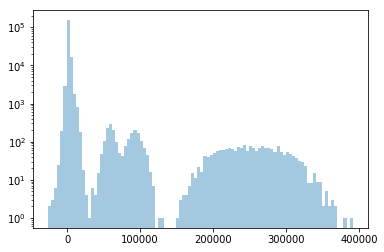

In [21]:
sns.distplot(data1[anatomy_sum_cols + anatomy_diff_cols].values.ravel(), kde=False, bins=100)
plt.yscale('log')

Standardize on train dataset

In [22]:
f1_stats = {}

for c in cols:
    mean = data1.loc[is_train, c].mean()
    std = data1.loc[is_train, c].std()
    f1_stats[c] = [mean, std]
    data1.loc[:, c] = (data1[c] - mean) / (std + 1e-12)

In [23]:
data1[cols].head()

anatomy_3rd-Ventricle  anatomy_4th-Ventricle  \
subject_id                                                           
1932355398536124106               -0.867358              -0.454509   
5174041730092253771                0.482676               0.388273   
10219322676643534800               0.020260               0.873000   
10645466564919190227              -1.231194               0.106819   
14512541342641936232              -1.483386              -0.745978   

                      anatomy_Brain-Stem  anatomy_CSF  \
subject_id                                              
1932355398536124106            -0.896388    -0.766443   
5174041730092253771             1.276704     0.373348   
10219322676643534800            0.018487    -0.332616   
10645466564919190227           -1.135729    -1.229699   
14512541342641936232            0.643279    -0.713469   

                      anatomy_WM-hypointensities  anatomy_Optic-Chiasm  \
subject_id                                                               
1932355398536124106                    -1.180306              1.894488   
5174041730092253771                    -0.899017             -0.080757   
10219322676643534800                   -0.855557              0.743079   
10645466564919190227                    0.385774              0.058511   
14512541342641936232                   -0.774627             -0.084680   

                      anatomy_CC_Posterior  anatomy_CC_Mid_Posterior  \
subject_id                                                             
1932355398536124106              -0.898136                 -0.599880   
5174041730092253771              -0.052494                  0.690828   
10219322676643534800             -0.147365                  0.111664   
10645466564919190227             -1.281134                  0.353442   
14512541342641936232              1.220068                  0.644862   

                      anatomy_CC_Central  anatomy_CC_Mid_Anterior  \
subject_id                                                          
1932355398536124106            -1.015271                -1.191568   
5174041730092253771            -0.469759                -0.505083   
10219322676643534800            1.117123                 1.422970   
10645466564919190227           -0.269806                -0.867875   
14512541342641936232            2.377905                 2.777351   

                                                             ...                                           \
subject_id                                                   ...                                            
1932355398536124106                                          ...                                            
5174041730092253771                                          ...                                            
10219322676643534800                                         ...                                            
10645466564919190227                                         ...                                            
14512541342641936232                                         ...                                            

                      (anatomy_lh_superiorparietal_area - anatomy_rh_superiorparietal_area)  \
subject_id                                                                                    
1932355398536124106                                            0.175348                       
5174041730092253771                                           -0.040558                       
10219322676643534800                                          -0.271750                       
10645466564919190227                                          -1.150659                       
14512541342641936232                                           0.412271                       

                      (anatomy_lh_superiorparietal_thickness - anatomy_rh_superiorparietal_thickness)  \
subject_id                                                                              

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


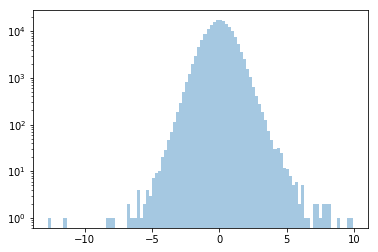

In [24]:
sns.distplot(data1[anatomy_sum_cols + anatomy_diff_cols].values.ravel(), kde=False, bins=100)
plt.yscale('log')

### Feature extraction and filtering

In [26]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(20, 10))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    if feature_names is not None:
        feature_names = np.array(feature_names)
        plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

### Single features filtering by model feature importance

In [27]:
cols = anatomy_cols + anatomy_diff_cols + anatomy_sum_cols + participant_cols

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

n_jobs=1
seed = 42
        
log_reg = LogisticRegression(random_state=seed)
log_reg.fit(data1.loc[is_train, cols], data1.loc[is_train, 'target'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

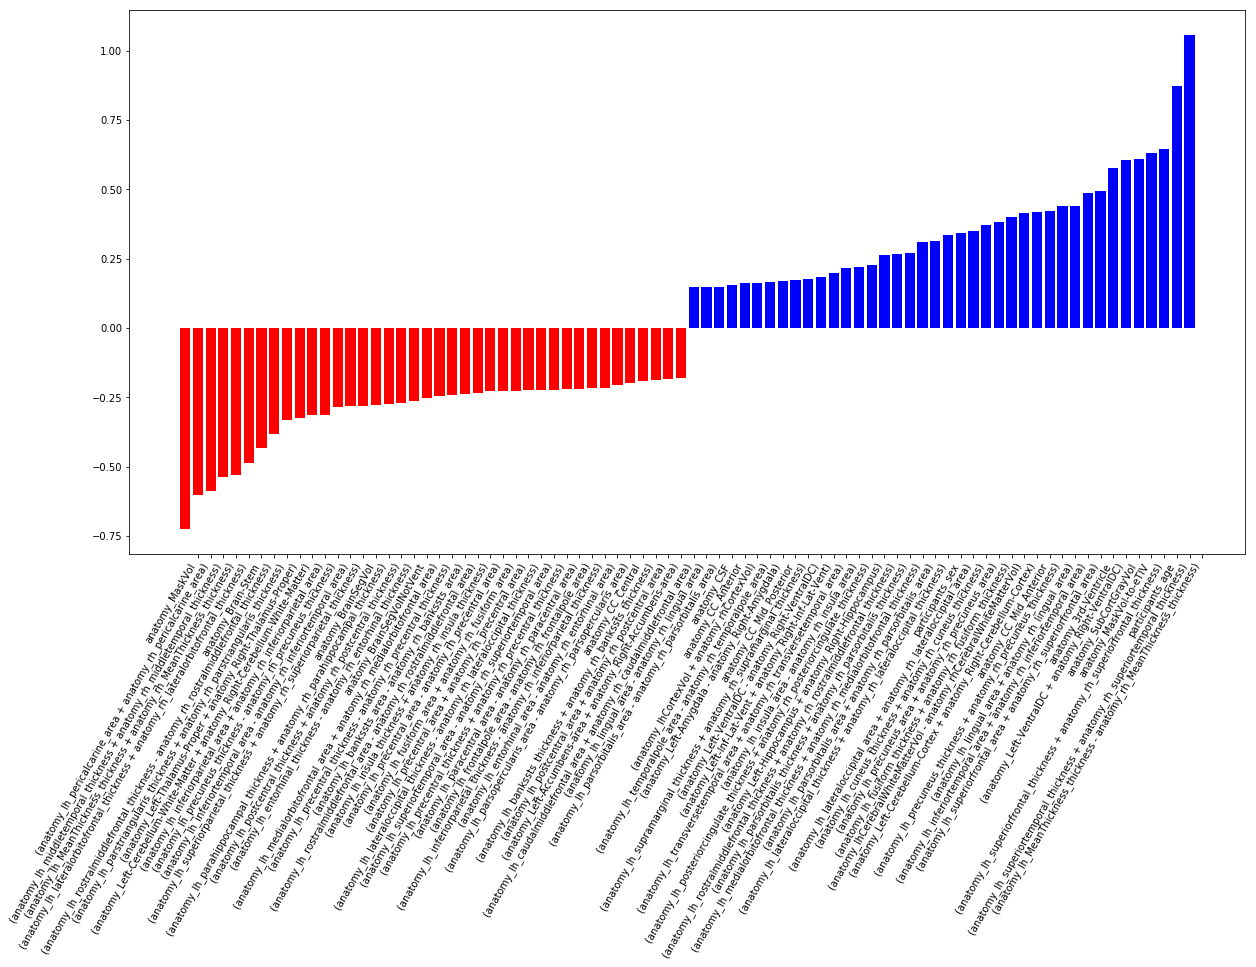

In [29]:
visualize_coefficients(log_reg, feature_names=cols, n_top_features=40)

In [30]:
coef = log_reg.coef_.ravel()

coef.min(), coef.max(), np.abs(coef).min()

(-0.7257870963209472, 1.0565399635821782, 0.00338692184526178)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


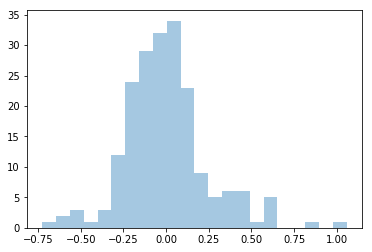

In [31]:
sns.distplot(coef, kde=False)

In [32]:
from itertools import product

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold


seed = 90
       

class FeatureExtractor(BaseEstimator, TransformerMixin):
        
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        return X_df
    

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(
                                StandardScaler(),
                                LogisticRegressionCV(n_jobs=8,
                                                     # cv=StratifiedKFold(n_splits=5, random_state=seed),                                                    
                                                     scoring="roc_auc", 
                                                     random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(
                                 StandardScaler(),
                                 LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

Grid search

In [32]:
neg_thresholds = np.linspace(-0.15, -0.25, 12)
pos_thresholds = np.linspace(0.15, 0.25, 12)


In [37]:
best_roc = 0.0
best_thresholds = None
max_early_stopping = 60
c = max_early_stopping

for i, (neg_threshold, pos_threshold) in enumerate(product(neg_thresholds, pos_thresholds)):
    print("Trial: ", i, neg_threshold, pos_threshold, end=" -> ")
    positive_coefficients = np.where(coef > pos_threshold)[0]
    negative_coefficients = np.where(coef < neg_threshold)[0]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    top_1_selected_columns = np.array(cols)[interesting_coefficients].tolist()
        
    results = evaluation(data1.loc[is_train, top_1_selected_columns], data1.loc[is_train, 'target'], verbose=False)
    
    current_roc = np.mean(results['test_roc_auc'])
    print(current_roc)
    c -= 1
    if current_roc > best_roc:
        best_thresholds = (neg_threshold, pos_threshold)
        best_roc = current_roc
        c = max_early_stopping
    
    if c == 0:
        print("Stop by early stopping")
        break

Trial:  0 -0.15 0.15 -> 0.7063930566519314
Trial:  1 -0.15 0.1590909090909091 -> 0.7071525312426161
Trial:  2 -0.15 0.16818181818181818 -> 0.7092230362616181
Trial:  3 -0.15 0.17727272727272728 -> 0.7054159538053539
Trial:  4 -0.15 0.18636363636363637 -> 0.7047240558477355
Trial:  5 -0.15 0.19545454545454546 -> 0.7047240558477355
Trial:  6 -0.15 0.20454545454545453 -> 0.7039085748393451
Trial:  7 -0.15 0.21363636363636362 -> 0.7039085748393451
Trial:  8 -0.15 0.22272727272727272 -> 0.7010879374915735
Trial:  9 -0.15 0.2318181818181818 -> 0.7029179098696712
Trial:  10 -0.15 0.2409090909090909 -> 0.7029179098696712
Trial:  11 -0.15 0.25 -> 0.7029179098696712
Trial:  12 -0.1590909090909091 0.15 -> 0.7082391350419641
Trial:  13 -0.1590909090909091 0.1590909090909091 -> 0.7089081318604824
Trial:  14 -0.1590909090909091 0.16818181818181818 -> 0.7107092729196822
Trial:  15 -0.1590909090909091 0.17727272727272728 -> 0.7073603281859164
Trial:  16 -0.1590909090909091 0.18636363636363637 -> 0.706

Trial:  118 -0.2318181818181818 0.2409090909090909 -> 0.6969194433641095
Trial:  119 -0.2318181818181818 0.25 -> 0.6969194433641095
Trial:  120 -0.2409090909090909 0.15 -> 0.7009038208822858
Trial:  121 -0.2409090909090909 0.1590909090909091 -> 0.7028973080940709
Trial:  122 -0.2409090909090909 0.16818181818181818 -> 0.7041979536938053
Stop by early stopping


In [38]:
# best_thresholds = (-0.1590909090909091, 0.1590909090909091)
best_thresholds

(-0.19545454545454546, 0.16818181818181818)

In [39]:
# neg_threshold = 0.27 * coef.min()
# pos_threshold = 0.127 * coef.max()
neg_threshold, pos_threshold = best_thresholds
print(neg_threshold, pos_threshold)

positive_coefficients = np.where(coef > pos_threshold)[0]
negative_coefficients = np.where(coef < neg_threshold)[0]

print(len(positive_coefficients), len(negative_coefficients), len(coef))

interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
top_1_selected_columns = np.array(cols)[interesting_coefficients].tolist()

results = evaluation(data1.loc[is_train, top_1_selected_columns], data1.loc[is_train, 'target'], verbose=True)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

-0.19545454545454546 0.16818181818181818
34 36 198
Training score ROC-AUC: 0.831 +- 0.011
Validation score ROC-AUC: 0.716 +- 0.019 

Training score accuracy: 0.751 +- 0.009
Validation score accuracy: 0.657 +- 0.019


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.3s finished



```
-0.19545454545454546 0.16818181818181818
34 36 198
Training score ROC-AUC: 0.831 +- 0.011
Validation score ROC-AUC: 0.716 +- 0.019 

Training score accuracy: 0.751 +- 0.009
Validation score accuracy: 0.657 +- 0.019
```

In [40]:
print("[", end="")
for f in top_1_selected_columns:
    print("\"{}\"".format(f), end=", ")
print("]")

["anatomy_Brain-Stem", "anatomy_CC_Central", "anatomy_BrainSegVol", "anatomy_MaskVol", "anatomy_BrainSegVolNotVent", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area)", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostr

In [42]:

# f1_columns = ["anatomy_Brain-Stem", "anatomy_CC_Central", "anatomy_BrainSegVol", "anatomy_MaskVol", "anatomy_BrainSegVolNotVent", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area)", "(anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "anatomy_3rd-Ventricle", "anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Anterior", "anatomy_SubCortGrayVol", "anatomy_MaskVol-to-eTIV", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_supramarginal_thickness + anatomy_rh_supramarginal_thickness)", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "participants_sex", "participants_age", ]

# len(f1_columns)


70

In [23]:


_f1_columns = ["anatomy_Brain-Stem", "anatomy_BrainSegVol", "anatomy_MaskVol", "anatomy_BrainSegVolNotVent", "(anatomy_lhCortexVol - anatomy_rhCortexVol)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "anatomy_3rd-Ventricle", "anatomy_CSF", "anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Anterior", "anatomy_CC_Anterior", "anatomy_SubCortGrayVol", "anatomy_MaskVol-to-eTIV", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "participants_sex", "participants_age", ]

len(_f1_columns)


77

In [34]:
# set(f1_columns) - set(_f1_columns)

In [35]:
# set(_f1_columns) - set(f1_columns)

In [24]:

f1_columns = _f1_columns

In [27]:
# results = evaluation(data1[f1_columns], data1['target'], verbose=True)

# print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
#                                                         np.std(results['train_roc_auc'])))
# print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
#                                                              np.std(results['test_roc_auc'])))

# print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
#                                                          np.std(results['train_accuracy'])))
# print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
#                                                            np.std(results['test_accuracy'])))

In [39]:
# results = evaluation(data1[_f1_columns], data1['target'], verbose=True)

# print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
#                                                         np.std(results['train_roc_auc'])))
# print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
#                                                              np.std(results['test_roc_auc'])))

# print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
#                                                          np.std(results['train_accuracy'])))
# print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
#                                                            np.std(results['test_accuracy'])))

In [25]:
# sns.distplot(data1[f1_columns].values.ravel(), kde=False, bins=100)
# plt.yscale('log')

In [26]:
# sns.distplot(data1[anatomy_cols].values.ravel(), kde=False, bins=100)
# plt.yscale('log')

In [27]:
# sns.distplot(data1[anatomy_diff_cols + anatomy_sum_cols].values.ravel(), kde=False, bins=100)
# plt.yscale('log')

In [28]:
len(f1_columns)

77

Polynomial 2nd degree



In [118]:
train_columns = f1_columns

In [119]:
data_ = data1[train_columns].values
data_.shape

(1031, 77)

In [120]:
pairs_columns = []

n = len(train_columns) * (len(train_columns) - 1)
pairs_data = np.zeros((len(data_), n))

c = 0
for i, f1 in enumerate(train_columns):    
    for j, f2 in enumerate(train_columns):
        if i < j:
                        
            pairs_columns.append("{} x {}".format(f1, f2))
            pairs_data[:, c] = data_[:, i] * data_[:, j]
            c += 1
            
            pairs_columns.append("{} / {}".format(f1, f2))

#             pairs_data[:, c] = data_[:, i] / (data_[:, j] + 1e-12)
            
            v = np.zeros_like(data_[:, j])
            m = np.abs(data_[:, j]) > 1e-1
            v[m] = data_[m, i] / data_[m, j]
            pairs_data[:, c] = v
            
            c += 1

In [121]:
pairs_df = pd.DataFrame(pairs_data, columns=pairs_columns, index=data1.index)

In [122]:
pairs_columns = pairs_df.columns.values.tolist()
pairs_df.shape

(1031, 5852)

In [123]:
# data2a = pd.concat([data1, pairs_df], axis=1)
data2b = pd.concat([data1, pairs_df], axis=1)

In [124]:
train_columns = anatomy_cols + anatomy_diff_cols + anatomy_sum_cols + participant_cols + pairs_columns
len(train_columns)

6050

In [53]:
data2a[train_columns].head()

anatomy_3rd-Ventricle  anatomy_4th-Ventricle  \
subject_id                                                           
1932355398536124106               -0.867358              -0.454509   
5174041730092253771                0.482676               0.388273   
10219322676643534800               0.020260               0.873000   
10645466564919190227              -1.231194               0.106819   
14512541342641936232              -1.483386              -0.745978   

                      anatomy_Brain-Stem  anatomy_CSF  \
subject_id                                              
1932355398536124106            -0.896388    -0.766443   
5174041730092253771             1.276704     0.373348   
10219322676643534800            0.018487    -0.332616   
10645466564919190227           -1.135729    -1.229699   
14512541342641936232            0.643279    -0.713469   

                      anatomy_WM-hypointensities  anatomy_Optic-Chiasm  \
subject_id                                                               
1932355398536124106                    -1.180306              1.894488   
5174041730092253771                    -0.899017             -0.080757   
10219322676643534800                   -0.855557              0.743079   
10645466564919190227                    0.385774              0.058511   
14512541342641936232                   -0.774627             -0.084680   

                      anatomy_CC_Posterior  anatomy_CC_Mid_Posterior  \
subject_id                                                             
1932355398536124106              -0.898136                 -0.599880   
5174041730092253771              -0.052494                  0.690828   
10219322676643534800             -0.147365                  0.111664   
10645466564919190227             -1.281134                  0.353442   
14512541342641936232              1.220068                  0.644862   

                      anatomy_CC_Central  anatomy_CC_Mid_Anterior  \
subject_id                                                          
1932355398536124106            -1.015271                -1.191568   
5174041730092253771            -0.469759                -0.505083   
10219322676643534800            1.117123                 1.422970   
10645466564919190227           -0.269806                -0.867875   
14512541342641936232            2.377905                 2.777351   

                                     ...                   \
subject_id                           ...                    
1932355398536124106                  ...                    
5174041730092253771                  ...                    
10219322676643534800                 ...                    
10645466564919190227                 ...                    
14512541342641936232                 ...                    

                      (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x participants_sex  \
subject_id                                                                                                         
1932355398536124106                                           -1.347249                                            
5174041730092253771                                            1.394965                                            
10219322676643534800                                           0.869356                                            
10645466564919190227                                           0.327134                                            
14512541342641936232                                           1.572814                                            

                      (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) / participants_sex  \
subject_id                                                                                                         
1932355398536124106                                           -1.347249                                            
5174041730092253771               

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


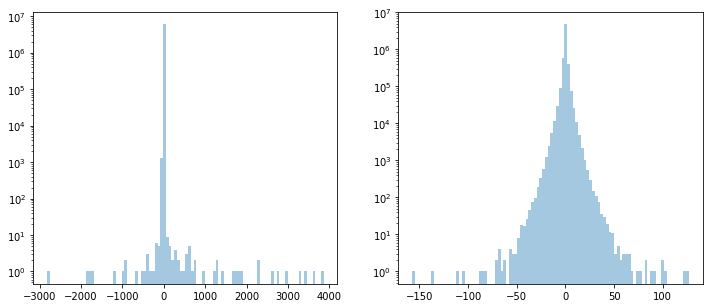

In [125]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.distplot(data2a[pairs_columns].values.ravel(), kde=False, bins=100)
plt.yscale('log')
plt.subplot(122)
sns.distplot(data2b[pairs_columns].values.ravel(), kde=False, bins=100)
plt.yscale('log')

In [126]:
# _cols = data2[pairs_columns].columns[(data2[pairs_columns] > 5e4).any(axis=0)]
# _cols

# sns.distplot(data2[_cols].values.ravel(), kde=False, bins=100)
# plt.yscale('log')

In [127]:
# data2r = data2.copy()

In [56]:
# f2_stats = {}

for c in pairs_columns:
    mean = data2a.loc[is_train, c].mean()
    std = data2a.loc[is_train, c].std()
#     f2_stats[c] = [mean, std]
    data2a.loc[:, c] = (data2a[c] - mean) / (std + 1e-12)    

In [128]:
f2_stats = {}

for c in pairs_columns:
    mean = data2b.loc[is_train, c].mean()
    std = data2b.loc[is_train, c].std()
    f2_stats[c] = [mean, std]
    data2b.loc[:, c] = (data2b[c] - mean) / (std + 1e-12)    

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


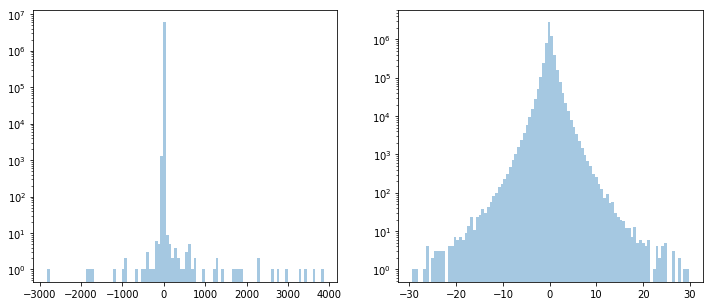

In [129]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.distplot(data2a[pairs_columns].values.ravel(), kde=False, bins=100)
plt.yscale('log')
plt.subplot(122)
sns.distplot(data2b[pairs_columns].values.ravel(), kde=False, bins=100)
plt.yscale('log')

In [71]:
data2b[pairs_columns].head()

anatomy_Brain-Stem x anatomy_BrainSegVol  \
subject_id                                                       
1932355398536124106                                   0.508493   
5174041730092253771                                   0.213437   
10219322676643534800                                 -0.516211   
10645466564919190227                                 -0.141539   
14512541342641936232                                 -0.434751   

                      anatomy_Brain-Stem / anatomy_BrainSegVol  \
subject_id                                                       
1932355398536124106                                  -0.054752   
5174041730092253771                                   0.111224   
10219322676643534800                                 -0.145470   
10645466564919190227                                  0.259238   
14512541342641936232                                  0.592171   

                      anatomy_Brain-Stem x anatomy_MaskVol  \
subject_id                                                   
1932355398536124106                               0.590931   
5174041730092253771                               0.038947   
10219322676643534800                             -0.492709   
10645466564919190227                              0.163038   
14512541342641936232                             -0.383139   

                      anatomy_Brain-Stem / anatomy_MaskVol  \
subject_id                                                   
1932355398536124106                              -0.002168   
5174041730092253771                               0.294653   
10219322676643534800                             -0.098934   
10645466564919190227                              0.153762   
14512541342641936232                              0.432197   

                      anatomy_Brain-Stem x anatomy_BrainSegVolNotVent  \
subject_id                                                              
1932355398536124106                                          0.504644   
5174041730092253771                                          0.209101   
10219322676643534800                                        -0.513850   
10645466564919190227                                        -0.179691   
14512541342641936232                                        -0.402809   

                      anatomy_Brain-Stem / anatomy_BrainSegVolNotVent  \
subject_id                                                              
1932355398536124106                                         -0.050337   
5174041730092253771                                          0.134078   
10219322676643534800                                        -0.150602   
10645466564919190227                                         0.350974   
14512541342641936232                                         0.400431   

                      anatomy_Brain-Stem x (anatomy_lhCortexVol - anatomy_rhCortexVol)  \
subject_id                                                                               
1932355398536124106                                           -0.355588                  
5174041730092253771                                           -0.515147                  
10219322676643534800                                           0.053885                  
10645466564919190227                                           1.298863                  
14512541342641936232                                          -0.056905                  

                      anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol)  \
subject_id                                                                               
1932355398536124106                                           -0.235086                  
5174041730092253771                                           -0.338095                  
10219322676643534800                                          -0.002162                  
10645466564919190227                                           0.110651                  
14512541342641936232           

In [146]:
print("{", end="")
for f in f2_stats:
    print("'{}': {}".format(f, f2_stats[f]), end=", ")
print("}")

{'anatomy_Brain-Stem x anatomy_BrainSegVol': [0.5372677181348682, 1.0805540126269868], 'anatomy_Brain-Stem / anatomy_BrainSegVol': [0.8235926265125538, 2.3640980613117515], 'anatomy_Brain-Stem x anatomy_MaskVol': [0.48682117580949935, 1.0128067441493278], 'anatomy_Brain-Stem / anatomy_MaskVol': [1.026259043713807, 2.5368300131078443], 'anatomy_Brain-Stem x anatomy_BrainSegVolNotVent': [0.5352830171478503, 1.0818464649288921], 'anatomy_Brain-Stem / anatomy_BrainSegVolNotVent': [0.8364075530622979, 2.323070212915396], 'anatomy_Brain-Stem x (anatomy_lhCortexVol - anatomy_rhCortexVol)': [-0.04866492819954255, 1.0803942966405582], 'anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol)': [-0.04861542079275923, 2.6558792736397443], 'anatomy_Brain-Stem x (anatomy_lh_bankssts_area - anatomy_rh_bankssts_area)': [0.01169511116245602, 1.0198449531583205], 'anatomy_Brain-Stem / (anatomy_lh_bankssts_area - anatomy_rh_bankssts_area)': [0.033198256407773505, 2.4790268252986074], 'anatomy_Br

, '(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)': [-0.0005182671353710842, 1.049238272857557], '(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)': [0.004953228420758652, 2.4819537445961317], '(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)': [0.0489339807647367, 1.0336052608396173], '(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)': [0.05036565237666214, 2.8139880773986583], '(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)': [0.04622239463838433, 1.020585516380004], '(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_MeanThickness_thic

'(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)': [0.034791874648047456, 2.6761262235899554], '(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)': [-0.01060979732519914, 1.0259487435366856], '(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)': [-0.12332319703649845, 2.6644461323901503], '(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)': [-0.09826037317868765, 1.0287857465977859], '(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)': [-0.029209033438510897, 2.5438986127565424], '(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lhCortexVol + anatomy_rhCortexVol)': [0.3742353435001663, 1.0246219045101408], '(anatomy_lh_insula_thickness + 

, '(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)': [0.0021629627507035076, 1.0822756975509125], '(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)': [-0.03918094117932673, 2.7282263172686014], '(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)': [-0.01890680925136971, 0.9212645527319049], '(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)': [-0.09030355917568635, 2.706423250304494], '(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)': [-0.0031380709874502853, 1.1148680598109098], '(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)': [-0.08485725954430436, 2.5939896668355096], '(an

### Double features filtering by model feature importance

In [130]:
cols = pairs_columns
data2 = data2b

In [131]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

n_jobs=1
seed = 42

log_reg = LogisticRegression(random_state=seed)
log_reg.fit(data2.loc[is_train, cols], data2.loc[is_train, 'target'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

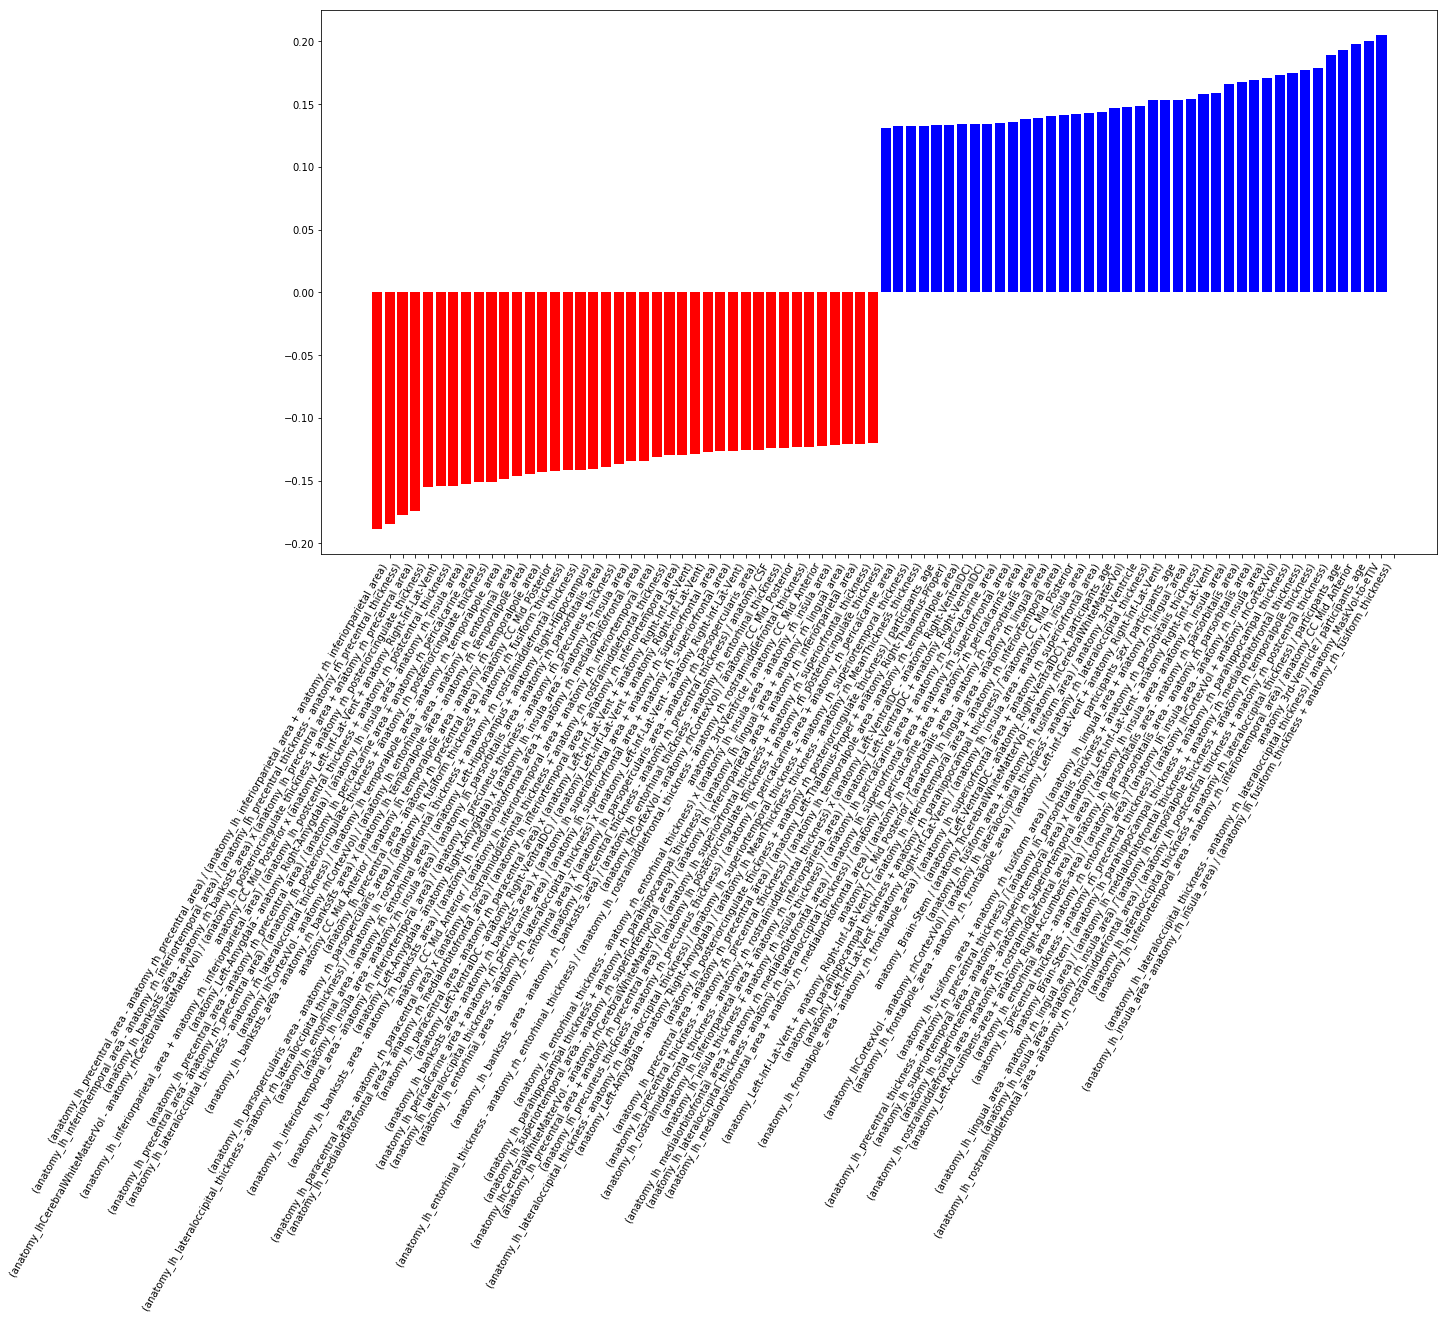

In [132]:
visualize_coefficients(log_reg, feature_names=cols, n_top_features=40)

In [133]:
coef = log_reg.coef_.ravel()

In [134]:
coef.min(), coef.max(), np.abs(coef).min()

(-0.18869354785945616, 0.2051273111005897, 3.0112222105715437e-05)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


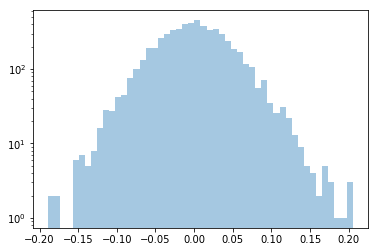

In [135]:
sns.distplot(coef, kde=False)
plt.yscale('log')

In [136]:
from itertools import product

In [137]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold


seed = 90
       

class FeatureExtractor(BaseEstimator, TransformerMixin):
        
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        return X_df
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(
            StandardScaler(),
            LogisticRegressionCV(n_jobs=8,
                                 # cv=StratifiedKFold(n_splits=5, random_state=seed),                                                    
                                 scoring="roc_auc",
                                 random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(
            StandardScaler(),
            LogisticRegression(C=best_C, random_state=seed)
        )
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

Grid search

In [138]:
# neg_thresholds = np.linspace(-0.07, -0.13, 15)
# pos_thresholds = np.linspace(0.07, 0.13, 15)

neg_thresholds = np.linspace(-0.05, -0.11, 15)
pos_thresholds = np.linspace(0.05, 0.11, 15)

In [139]:
best_roc = 0.0
best_thresholds = None
max_early_stopping = 60
# max_early_stopping = 2
c = max_early_stopping

for i, (neg_threshold, pos_threshold) in enumerate(product(neg_thresholds, pos_thresholds)):
    print("Trial: ", i, neg_threshold, pos_threshold, end=" -> ")
    positive_coefficients = np.where(coef > pos_threshold)[0]
    negative_coefficients = np.where(coef < neg_threshold)[0]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    top_2_selected_columns = np.array(cols)[interesting_coefficients].tolist()
        
    results = evaluation(data2.loc[is_train, top_2_selected_columns], data2.loc[is_train, 'target'], verbose=False)
    
    current_roc = np.mean(results['test_roc_auc'])
    print(current_roc)
    c -= 1
    if current_roc > best_roc:
        best_thresholds = (neg_threshold, pos_threshold)
        best_roc = current_roc
        c = max_early_stopping
    
    if c == 0:
        print("Stop by early stopping")
        break    

Trial:  0 -0.05 0.05 -> 0.9196295158801393
Trial:  1 -0.05 0.05428571428571429 -> 0.9235010446526065
Trial:  2 -0.05 0.05857142857142857 -> 0.9246795810215586
Trial:  3 -0.05 0.06285714285714286 -> 0.9193356423439842
Trial:  4 -0.05 0.06714285714285714 -> 0.9119892301610125
Trial:  5 -0.05 0.07142857142857142 -> 0.902323873831105
Trial:  6 -0.05 0.07571428571428572 -> 0.8957744621722045
Trial:  7 -0.05 0.08 -> 0.8831302480948852
Trial:  8 -0.05 0.0842857142857143 -> 0.8780317788129366
Trial:  9 -0.05 0.08857142857142858 -> 0.8701247271213722
Trial:  10 -0.05 0.09285714285714286 -> 0.8482615283846184
Trial:  11 -0.05 0.09714285714285714 -> 0.8365357846175728
Trial:  12 -0.05 0.10142857142857144 -> 0.8285951163282623
Trial:  13 -0.05 0.10571428571428572 -> 0.8208315597949273
Trial:  14 -0.05 0.11 -> 0.8123654991243512
Trial:  15 -0.05428571428571429 0.05 -> 0.9203026752154013
Trial:  16 -0.05428571428571429 0.05428571428571429 -> 0.9236635050179502
Trial:  17 -0.05428571428571429 0.05857

In [140]:
# best_thresholds = (-0.055, 0.06)
best_thresholds

(-0.05428571428571429, 0.05857142857142857)

In [141]:
# neg_threshold = 0.27 * coef.min()
# pos_threshold = 0.127 * coef.max()
neg_threshold, pos_threshold = best_thresholds
print(neg_threshold, pos_threshold)

positive_coefficients = np.where(coef > pos_threshold)[0]
negative_coefficients = np.where(coef < neg_threshold)[0]

print(len(negative_coefficients), len(positive_coefficients), len(coef))

interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
top_2_selected_columns = np.array(cols)[interesting_coefficients].tolist()

results = evaluation(data2.loc[is_train, top_2_selected_columns], data2.loc[is_train, 'target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

-0.05428571428571429 0.05857142857142857
700 609 5852
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.926 +- 0.012 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.852 +- 0.015


zero tolerance : 1e-1
```
-0.05428571428571429 0.05857142857142857
700 609 5852
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.926 +- 0.012 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.852 +- 0.015
```

zero tolerance : 1e-2
```
672 616 5852
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.935 +- 0.008 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.866 +- 0.011
```

In [142]:
print("[", end="")
for f in top_2_selected_columns:
    print("\"{}\"".format(f), end=", ")
print("]")

["anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol)", "anatomy_Brain-Stem / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "anatomy_Brain-Stem / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "anatomy_Brain-Stem / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "anatomy_Brain-Stem / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "anatomy_Brain-Stem / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "anatomy_Brain-Stem / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "anatomy_Brain-Stem / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "anatomy_Brain-Stem / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "anatomy_Brain-Stem / anatomy_CC_Anterior", "anatomy_Brain-Stem / anatomy_SubCortGrayVol", "anatomy_Brain-Stem / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "anatomy_Brain-Stem / (anato

In [143]:
# tol 1e-1
f2_columns = ["anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol)", "anatomy_Brain-Stem / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "anatomy_Brain-Stem / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "anatomy_Brain-Stem / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "anatomy_Brain-Stem / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "anatomy_Brain-Stem / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "anatomy_Brain-Stem / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "anatomy_Brain-Stem / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "anatomy_Brain-Stem / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "anatomy_Brain-Stem / anatomy_CC_Anterior", "anatomy_Brain-Stem / anatomy_SubCortGrayVol", "anatomy_Brain-Stem / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "anatomy_Brain-Stem / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "anatomy_Brain-Stem / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "anatomy_Brain-Stem / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "anatomy_Brain-Stem x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "anatomy_Brain-Stem x participants_sex", "anatomy_Brain-Stem / participants_sex", "anatomy_BrainSegVol / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "anatomy_BrainSegVol / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "anatomy_BrainSegVol / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "anatomy_BrainSegVol / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "anatomy_BrainSegVol / anatomy_CC_Mid_Posterior", "anatomy_BrainSegVol / anatomy_SubCortGrayVol", "anatomy_BrainSegVol / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "anatomy_BrainSegVol x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "anatomy_BrainSegVol x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "anatomy_MaskVol x (anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "anatomy_MaskVol / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "anatomy_MaskVol / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "anatomy_MaskVol / anatomy_CC_Mid_Anterior", "anatomy_MaskVol / anatomy_SubCortGrayVol", "anatomy_MaskVol / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "anatomy_MaskVol / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "anatomy_MaskVol x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_MaskVol / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "anatomy_BrainSegVolNotVent / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "anatomy_BrainSegVolNotVent / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "anatomy_BrainSegVolNotVent / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "anatomy_BrainSegVolNotVent / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "anatomy_BrainSegVolNotVent x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "anatomy_BrainSegVolNotVent x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_3rd-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_CC_Mid_Posterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_CC_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x participants_age", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_SubCortGrayVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x participants_age", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / participants_age", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_SubCortGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / participants_age", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x participants_age", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / participants_age", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x participants_age", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / participants_age", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x participants_sex", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / participants_sex", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x participants_age", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x participants_age", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / participants_age", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_CSF", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / anatomy_CC_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x participants_age", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x participants_age", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / participants_age", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_3rd-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_SubCortGrayVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x participants_sex", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / participants_sex", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_sex", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / participants_sex", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_age", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x participants_age", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / anatomy_3rd-Ventricle", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / anatomy_CC_Mid_Posterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / anatomy_CC_Mid_Anterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x participants_sex", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / participants_sex", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x participants_age", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Mid_Anterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Anterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / anatomy_CC_Mid_Anterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_CC_Mid_Posterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_SubCortGrayVol", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x participants_sex", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / participants_sex", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x participants_age", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / participants_age", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_3rd-Ventricle", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / participants_age", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_SubCortGrayVol", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x participants_sex", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / participants_sex", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / participants_age", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / anatomy_CSF", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / anatomy_CC_Anterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x participants_sex", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / participants_sex", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_CSF", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x participants_age", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / participants_age", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / anatomy_CC_Mid_Posterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / anatomy_CC_Anterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "anatomy_3rd-Ventricle / anatomy_CSF", "anatomy_3rd-Ventricle / anatomy_CC_Mid_Posterior", "anatomy_3rd-Ventricle x anatomy_CC_Mid_Anterior", "anatomy_3rd-Ventricle / anatomy_CC_Mid_Anterior", "anatomy_3rd-Ventricle x anatomy_SubCortGrayVol", "anatomy_3rd-Ventricle x anatomy_MaskVol-to-eTIV", "anatomy_3rd-Ventricle / anatomy_MaskVol-to-eTIV", "anatomy_3rd-Ventricle x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "anatomy_3rd-Ventricle x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_3rd-Ventricle / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "anatomy_3rd-Ventricle x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "anatomy_3rd-Ventricle / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "anatomy_3rd-Ventricle x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "anatomy_3rd-Ventricle x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "anatomy_CSF / anatomy_CC_Mid_Posterior", "anatomy_CSF x anatomy_SubCortGrayVol", "anatomy_CSF x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_CSF x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "anatomy_CSF x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "anatomy_CC_Mid_Posterior / anatomy_CC_Anterior", "anatomy_CC_Mid_Posterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "anatomy_CC_Mid_Posterior x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_CC_Mid_Posterior / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "anatomy_CC_Mid_Posterior x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "anatomy_CC_Mid_Posterior / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "anatomy_CC_Mid_Posterior x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "anatomy_CC_Mid_Posterior x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "anatomy_CC_Mid_Posterior x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "anatomy_CC_Mid_Posterior / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "anatomy_CC_Mid_Posterior / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "anatomy_CC_Mid_Anterior / anatomy_SubCortGrayVol", "anatomy_CC_Mid_Anterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "anatomy_CC_Mid_Anterior x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "anatomy_CC_Mid_Anterior x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_CC_Mid_Anterior x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "anatomy_CC_Mid_Anterior x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "anatomy_CC_Mid_Anterior / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "anatomy_CC_Mid_Anterior / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "anatomy_CC_Mid_Anterior x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "anatomy_CC_Mid_Anterior x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "anatomy_CC_Mid_Anterior x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "anatomy_CC_Anterior / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "anatomy_CC_Anterior / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "anatomy_CC_Anterior x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "anatomy_CC_Anterior / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "anatomy_CC_Anterior x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "anatomy_CC_Anterior / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "anatomy_CC_Anterior x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "anatomy_SubCortGrayVol / anatomy_MaskVol-to-eTIV", "anatomy_SubCortGrayVol / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_SubCortGrayVol / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "anatomy_MaskVol-to-eTIV / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "anatomy_MaskVol-to-eTIV / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_MaskVol-to-eTIV x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_MaskVol-to-eTIV / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_MaskVol-to-eTIV x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "anatomy_MaskVol-to-eTIV x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_MaskVol-to-eTIV / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "anatomy_MaskVol-to-eTIV / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "anatomy_MaskVol-to-eTIV / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "anatomy_MaskVol-to-eTIV / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "anatomy_MaskVol-to-eTIV x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "anatomy_MaskVol-to-eTIV / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "anatomy_MaskVol-to-eTIV / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lhCortexVol + anatomy_rhCortexVol) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lhCortexVol + anatomy_rhCortexVol) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lhCortexVol + anatomy_rhCortexVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "anatomy_Brain-Stem x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "anatomy_Brain-Stem / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "anatomy_Brain-Stem / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "anatomy_Brain-Stem / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "anatomy_Brain-Stem / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_Brain-Stem x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "anatomy_Brain-Stem / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_Brain-Stem / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "anatomy_Brain-Stem x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "anatomy_BrainSegVol / (anatomy_lh_bankssts_area - anatomy_rh_bankssts_area)", "anatomy_BrainSegVol / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "anatomy_BrainSegVol x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "anatomy_MaskVol / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "anatomy_MaskVol / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "anatomy_MaskVol / participants_age", "anatomy_BrainSegVolNotVent / (anatomy_lh_bankssts_area - anatomy_rh_bankssts_area)", "anatomy_BrainSegVolNotVent / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "anatomy_BrainSegVolNotVent x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x anatomy_SubCortGrayVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_CC_Mid_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_3rd-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CSF", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_CC_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / anatomy_3rd-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / anatomy_CC_Mid_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / anatomy_3rd-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_3rd-Ventricle", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_CSF", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CSF", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / participants_age", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_CSF", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_CC_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_CC_Mid_Posterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_SubCortGrayVol", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / anatomy_CSF", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "anatomy_3rd-Ventricle / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "anatomy_3rd-Ventricle / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_3rd-Ventricle x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "anatomy_3rd-Ventricle / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "anatomy_3rd-Ventricle / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "anatomy_3rd-Ventricle x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "anatomy_3rd-Ventricle / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "anatomy_3rd-Ventricle / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "anatomy_3rd-Ventricle / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "anatomy_3rd-Ventricle x participants_sex", "anatomy_3rd-Ventricle / participants_sex", "anatomy_3rd-Ventricle x participants_age", "anatomy_3rd-Ventricle / participants_age", "anatomy_CSF / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "anatomy_CSF x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_CSF / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_CSF x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "anatomy_CSF / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_CSF / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "anatomy_CSF / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "anatomy_CSF / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "anatomy_CSF / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "anatomy_CSF / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "anatomy_CSF / participants_age", "anatomy_CC_Mid_Posterior x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "anatomy_CC_Mid_Posterior / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "anatomy_CC_Mid_Posterior x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "anatomy_CC_Mid_Posterior / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "anatomy_CC_Mid_Posterior / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "anatomy_CC_Mid_Posterior x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "anatomy_CC_Mid_Posterior / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "anatomy_CC_Mid_Posterior / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "anatomy_CC_Mid_Posterior / participants_age", "anatomy_CC_Mid_Anterior x anatomy_CC_Anterior", "anatomy_CC_Mid_Anterior / anatomy_MaskVol-to-eTIV", "anatomy_CC_Mid_Anterior / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "anatomy_CC_Mid_Anterior x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "anatomy_CC_Mid_Anterior x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "anatomy_CC_Mid_Anterior x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "anatomy_CC_Mid_Anterior / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "anatomy_CC_Mid_Anterior / participants_age", "anatomy_CC_Anterior / anatomy_MaskVol-to-eTIV", "anatomy_CC_Anterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "anatomy_CC_Anterior / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "anatomy_CC_Anterior x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "anatomy_CC_Anterior x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_CC_Anterior / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_CC_Anterior / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "anatomy_CC_Anterior x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "anatomy_CC_Anterior / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "anatomy_CC_Anterior / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "anatomy_CC_Anterior x participants_age", "anatomy_CC_Anterior / participants_age", "anatomy_SubCortGrayVol / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_SubCortGrayVol x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "anatomy_SubCortGrayVol x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "anatomy_SubCortGrayVol x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x participants_sex", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / participants_sex", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / participants_age", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_sex", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / participants_sex", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_age", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x participants_sex", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / participants_sex", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x participants_age", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / participants_age", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x participants_sex", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / participants_sex", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / participants_age", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / participants_age", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x participants_sex", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / participants_sex", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x participants_age", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / participants_age", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x participants_sex", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / participants_sex", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x participants_age", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x participants_age", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / participants_age", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_sex", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_sex", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_age", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_age", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x participants_age", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / participants_age", "(anatomy_lhCortexVol + anatomy_rhCortexVol) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x participants_sex", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / participants_sex", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x participants_age", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x participants_sex", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_sex", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_age", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x participants_age", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x participants_sex", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / participants_sex", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x participants_age", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / participants_age", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x participants_age", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x participants_sex", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / participants_sex", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x participants_age", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / participants_age", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x participants_age", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / participants_age", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / participants_age", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x participants_age", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_sex", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_sex", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_age", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_age", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x participants_sex", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) / participants_sex", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x participants_age", "participants_sex x participants_age", "participants_sex / participants_age", ]

len(f2_columns)


1309

In [88]:
# tol 1e-2
_f2_columns = ["anatomy_Brain-Stem / (anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "anatomy_Brain-Stem x (anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness)", "anatomy_Brain-Stem / (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area)", "anatomy_Brain-Stem x (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "anatomy_Brain-Stem / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "anatomy_Brain-Stem / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "anatomy_Brain-Stem / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "anatomy_Brain-Stem / anatomy_CC_Mid_Anterior", "anatomy_Brain-Stem / anatomy_SubCortGrayVol", "anatomy_Brain-Stem / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "anatomy_Brain-Stem x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "anatomy_Brain-Stem x participants_sex", "anatomy_Brain-Stem / participants_sex", "anatomy_Brain-Stem x participants_age", "anatomy_Brain-Stem / participants_age", "anatomy_BrainSegVol / (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area)", "anatomy_BrainSegVol / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "anatomy_BrainSegVol / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "anatomy_BrainSegVol / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "anatomy_BrainSegVol / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "anatomy_BrainSegVol / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "anatomy_BrainSegVol / anatomy_CSF", "anatomy_BrainSegVol / anatomy_CC_Mid_Anterior", "anatomy_BrainSegVol / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "anatomy_BrainSegVol x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "anatomy_MaskVol x (anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "anatomy_MaskVol / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "anatomy_MaskVol / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "anatomy_MaskVol / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "anatomy_MaskVol / anatomy_MaskVol-to-eTIV", "anatomy_MaskVol x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_BrainSegVolNotVent / (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area)", "anatomy_BrainSegVolNotVent / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "anatomy_BrainSegVolNotVent / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "anatomy_BrainSegVolNotVent / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "anatomy_BrainSegVolNotVent / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "anatomy_BrainSegVolNotVent / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "anatomy_BrainSegVolNotVent / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "anatomy_BrainSegVolNotVent / anatomy_CSF", "anatomy_BrainSegVolNotVent / anatomy_CC_Mid_Anterior", "anatomy_BrainSegVolNotVent x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_bankssts_area - anatomy_rh_bankssts_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_3rd-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_CC_Mid_Posterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_CC_Mid_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x participants_age", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CSF", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x participants_age", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x participants_sex", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / participants_sex", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x participants_age", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x participants_age", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / participants_age", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_3rd-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / participants_age", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x participants_age", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / participants_age", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x participants_age", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / participants_age", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_CC_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_SubCortGrayVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x participants_age", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / participants_age", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_CSF", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / participants_age", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x participants_age", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / participants_age", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_sex", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / participants_sex", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_3rd-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_CC_Mid_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_CC_Mid_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_SubCortGrayVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / anatomy_CC_Mid_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / anatomy_CC_Mid_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_sex", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / participants_sex", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_age", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / participants_age", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / anatomy_CSF", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / anatomy_CC_Mid_Posterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / anatomy_CC_Mid_Anterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x participants_sex", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / participants_sex", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / anatomy_CSF", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / anatomy_CC_Mid_Anterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x participants_age", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / participants_age", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_CC_Anterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x participants_age", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / anatomy_CC_Mid_Posterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_CSF", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x participants_age", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / participants_age", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_CC_Mid_Anterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_CC_Anterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x participants_sex", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / participants_sex", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x participants_sex", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / participants_sex", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x participants_age", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / participants_age", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / anatomy_CSF", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / anatomy_CC_Mid_Anterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / anatomy_CC_Anterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x participants_sex", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / participants_sex", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_CSF", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / anatomy_3rd-Ventricle", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / anatomy_CSF", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / anatomy_CC_Anterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "anatomy_3rd-Ventricle x anatomy_CC_Anterior", "anatomy_3rd-Ventricle / anatomy_CC_Anterior", "anatomy_3rd-Ventricle x anatomy_MaskVol-to-eTIV", "anatomy_3rd-Ventricle / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "anatomy_3rd-Ventricle / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "anatomy_3rd-Ventricle x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_3rd-Ventricle / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "anatomy_3rd-Ventricle / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "anatomy_3rd-Ventricle / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "anatomy_CSF / anatomy_CC_Anterior", "anatomy_CSF / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "anatomy_CSF x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_CC_Mid_Posterior / anatomy_CC_Mid_Anterior", "anatomy_CC_Mid_Posterior / anatomy_SubCortGrayVol", "anatomy_CC_Mid_Posterior x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "anatomy_CC_Mid_Posterior x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "anatomy_CC_Mid_Posterior / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "anatomy_CC_Mid_Posterior x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "anatomy_CC_Mid_Posterior / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "anatomy_CC_Mid_Posterior x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "anatomy_CC_Mid_Posterior / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "anatomy_CC_Mid_Posterior / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "anatomy_CC_Mid_Posterior / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "anatomy_CC_Mid_Posterior x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "anatomy_CC_Mid_Posterior x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "anatomy_CC_Mid_Anterior / anatomy_SubCortGrayVol", "anatomy_CC_Mid_Anterior x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "anatomy_CC_Mid_Anterior x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "anatomy_CC_Mid_Anterior x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_CC_Mid_Anterior x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_CC_Mid_Anterior x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "anatomy_CC_Mid_Anterior x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "anatomy_CC_Mid_Anterior x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "anatomy_CC_Mid_Anterior / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "anatomy_CC_Mid_Anterior x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "anatomy_CC_Mid_Anterior / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "anatomy_CC_Mid_Anterior x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "anatomy_CC_Mid_Anterior / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "anatomy_CC_Anterior / anatomy_MaskVol-to-eTIV", "anatomy_CC_Anterior / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_CC_Anterior x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "anatomy_CC_Anterior / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "anatomy_CC_Anterior x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "anatomy_CC_Anterior x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "anatomy_CC_Anterior x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "anatomy_SubCortGrayVol / anatomy_MaskVol-to-eTIV", "anatomy_SubCortGrayVol / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "anatomy_MaskVol-to-eTIV / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_MaskVol-to-eTIV x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_MaskVol-to-eTIV x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "anatomy_MaskVol-to-eTIV x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_MaskVol-to-eTIV x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "anatomy_MaskVol-to-eTIV x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "anatomy_MaskVol-to-eTIV / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "anatomy_MaskVol-to-eTIV x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lhCortexVol + anatomy_rhCortexVol) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "anatomy_Brain-Stem / anatomy_BrainSegVol", "anatomy_Brain-Stem / (anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness)", "anatomy_Brain-Stem x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "anatomy_Brain-Stem / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "anatomy_Brain-Stem / anatomy_3rd-Ventricle", "anatomy_Brain-Stem / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "anatomy_Brain-Stem x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "anatomy_Brain-Stem / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "anatomy_Brain-Stem / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_Brain-Stem / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "anatomy_Brain-Stem / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "anatomy_Brain-Stem x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "anatomy_BrainSegVol / (anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "anatomy_BrainSegVol / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "anatomy_MaskVol / (anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "anatomy_MaskVol / (anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness)", "anatomy_MaskVol / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "anatomy_MaskVol / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "anatomy_BrainSegVolNotVent / (anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "anatomy_BrainSegVolNotVent / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_SubCortGrayVol", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_3rd-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_CC_Mid_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_3rd-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CSF", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / anatomy_SubCortGrayVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_CC_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_SubCortGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / anatomy_SubCortGrayVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_CSF", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / anatomy_CC_Mid_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / anatomy_SubCortGrayVol", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CSF", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_CC_Anterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Mid_Anterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_SubCortGrayVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / anatomy_3rd-Ventricle", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / anatomy_3rd-Ventricle", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_3rd-Ventricle", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_SubCortGrayVol", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_3rd-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_CC_Mid_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "anatomy_3rd-Ventricle / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_3rd-Ventricle x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "anatomy_3rd-Ventricle x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "anatomy_3rd-Ventricle / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "anatomy_3rd-Ventricle / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "anatomy_3rd-Ventricle x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "anatomy_3rd-Ventricle / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "anatomy_3rd-Ventricle x participants_sex", "anatomy_3rd-Ventricle / participants_sex", "anatomy_3rd-Ventricle x participants_age", "anatomy_3rd-Ventricle / participants_age", "anatomy_CSF / anatomy_CC_Mid_Posterior", "anatomy_CSF / anatomy_SubCortGrayVol", "anatomy_CSF / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "anatomy_CSF x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_CSF / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_CSF x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "anatomy_CSF / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_CSF / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "anatomy_CSF / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "anatomy_CSF / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "anatomy_CSF / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "anatomy_CSF x participants_age", "anatomy_CSF / participants_age", "anatomy_CC_Mid_Posterior / anatomy_CC_Anterior", "anatomy_CC_Mid_Posterior / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_CC_Mid_Posterior / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "anatomy_CC_Mid_Posterior / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "anatomy_CC_Mid_Posterior / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "anatomy_CC_Mid_Posterior x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "anatomy_CC_Mid_Posterior x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "anatomy_CC_Mid_Anterior x anatomy_CC_Anterior", "anatomy_CC_Mid_Anterior / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "anatomy_CC_Mid_Anterior / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "anatomy_CC_Mid_Anterior / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "anatomy_CC_Mid_Anterior x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "anatomy_CC_Mid_Anterior / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "anatomy_CC_Mid_Anterior / participants_age", "anatomy_CC_Anterior / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "anatomy_CC_Anterior x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_CC_Anterior / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "anatomy_CC_Anterior x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "anatomy_CC_Anterior / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "anatomy_CC_Anterior x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "anatomy_CC_Anterior / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "anatomy_CC_Anterior / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "anatomy_CC_Anterior x participants_age", "anatomy_SubCortGrayVol / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "anatomy_SubCortGrayVol / participants_age", "anatomy_MaskVol-to-eTIV / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "anatomy_MaskVol-to-eTIV / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "anatomy_MaskVol-to-eTIV / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "anatomy_MaskVol-to-eTIV / participants_age", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x participants_sex", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / participants_sex", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_sex", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / participants_sex", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_age", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / participants_age", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x participants_age", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / participants_age", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x participants_sex", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / participants_sex", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x participants_sex", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / participants_sex", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / participants_age", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / participants_age", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x participants_sex", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / participants_sex", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x participants_age", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x participants_sex", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / participants_sex", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x participants_age", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / participants_age", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x participants_age", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / participants_age", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_sex", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_sex", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_age", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x participants_age", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / participants_age", "(anatomy_lhCortexVol + anatomy_rhCortexVol) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lhCortexVol + anatomy_rhCortexVol) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x participants_sex", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / participants_sex", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x participants_age", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / participants_age", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x participants_sex", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_sex", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x participants_age", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_age", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x participants_age", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / participants_age", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x participants_sex", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / participants_sex", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x participants_age", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / participants_age", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x participants_age", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x participants_sex", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / participants_sex", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x participants_age", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x participants_sex", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / participants_sex", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x participants_age", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / participants_age", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / participants_age", "(anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) / participants_age", "(anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_sex", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_sex", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_age", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_age", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x participants_sex", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) / participants_sex", "participants_sex x participants_age", "participants_sex / participants_age", ]

len(f2_columns)


1288

In [89]:
# old stuff
__f2_columns = ["anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol)", "anatomy_Brain-Stem / (anatomy_lh_bankssts_area - anatomy_rh_bankssts_area)", "anatomy_Brain-Stem / (anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "anatomy_Brain-Stem x (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "anatomy_Brain-Stem / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "anatomy_Brain-Stem / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "anatomy_Brain-Stem x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "anatomy_Brain-Stem x participants_age", "anatomy_Brain-Stem / participants_age", "anatomy_BrainSegVol / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "anatomy_BrainSegVol x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "anatomy_BrainSegVol x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "anatomy_BrainSegVol x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "anatomy_BrainSegVol x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "anatomy_BrainSegVol x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "anatomy_MaskVol x (anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "anatomy_MaskVol / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "anatomy_MaskVol x anatomy_CC_Mid_Posterior", "anatomy_MaskVol x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "anatomy_MaskVol x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "anatomy_MaskVol x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_MaskVol x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "anatomy_BrainSegVolNotVent / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "anatomy_BrainSegVolNotVent x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "anatomy_BrainSegVolNotVent x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "anatomy_BrainSegVolNotVent x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_CC_Mid_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x participants_age", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / participants_age", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x participants_age", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x participants_sex", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / participants_sex", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_CSF", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_CC_Mid_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x participants_age", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / participants_age", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / participants_age", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x participants_age", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x participants_age", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / participants_age", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_CC_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x participants_age", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / participants_age", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CSF", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_CSF", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / anatomy_CC_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / participants_age", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x participants_age", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / participants_age", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_sex", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / participants_sex", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x participants_sex", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / participants_sex", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / anatomy_CC_Mid_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / anatomy_SubCortGrayVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_sex", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / participants_sex", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_age", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x participants_sex", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / participants_sex", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x participants_age", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x participants_age", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / participants_age", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CSF", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_CC_Anterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x participants_age", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / anatomy_CC_Mid_Posterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x participants_age", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / participants_age", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x participants_sex", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / participants_sex", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / participants_age", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x participants_sex", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / participants_sex", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x participants_age", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / participants_age", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Anterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x participants_sex", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / participants_sex", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Anterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / participants_age", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "anatomy_3rd-Ventricle / anatomy_CSF", "anatomy_3rd-Ventricle x anatomy_SubCortGrayVol", "anatomy_3rd-Ventricle / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "anatomy_3rd-Ventricle / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "anatomy_3rd-Ventricle x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_3rd-Ventricle / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "anatomy_3rd-Ventricle / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "anatomy_3rd-Ventricle x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "anatomy_CSF x anatomy_SubCortGrayVol", "anatomy_CSF x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "anatomy_CSF x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_CSF x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "anatomy_CC_Mid_Posterior / anatomy_SubCortGrayVol", "anatomy_CC_Mid_Posterior x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "anatomy_CC_Mid_Posterior x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "anatomy_CC_Mid_Posterior x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_CC_Mid_Posterior x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "anatomy_CC_Mid_Posterior / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "anatomy_CC_Mid_Posterior x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "anatomy_CC_Mid_Anterior / anatomy_SubCortGrayVol", "anatomy_CC_Mid_Anterior x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "anatomy_CC_Mid_Anterior x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_CC_Mid_Anterior x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_CC_Mid_Anterior x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "anatomy_CC_Mid_Anterior x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "anatomy_CC_Mid_Anterior x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "anatomy_CC_Mid_Anterior / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "anatomy_CC_Mid_Anterior x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "anatomy_CC_Anterior / anatomy_MaskVol-to-eTIV", "anatomy_CC_Anterior / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_CC_Anterior x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "anatomy_CC_Anterior x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "anatomy_CC_Anterior x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "anatomy_CC_Anterior x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "anatomy_SubCortGrayVol / anatomy_MaskVol-to-eTIV", "anatomy_SubCortGrayVol x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_SubCortGrayVol / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "anatomy_MaskVol-to-eTIV x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "anatomy_MaskVol-to-eTIV / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_MaskVol-to-eTIV x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_MaskVol-to-eTIV x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "anatomy_MaskVol-to-eTIV x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_MaskVol-to-eTIV x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "anatomy_MaskVol-to-eTIV x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "anatomy_Brain-Stem / (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area)", "anatomy_Brain-Stem x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "anatomy_Brain-Stem / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "anatomy_Brain-Stem / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "anatomy_Brain-Stem x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "anatomy_Brain-Stem / anatomy_3rd-Ventricle", "anatomy_Brain-Stem x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "anatomy_Brain-Stem x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "anatomy_Brain-Stem x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "anatomy_Brain-Stem / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "anatomy_BrainSegVol / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "anatomy_BrainSegVol / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "anatomy_BrainSegVol x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "anatomy_MaskVol / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "anatomy_MaskVol / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "anatomy_MaskVol / participants_age", "anatomy_BrainSegVolNotVent / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "anatomy_BrainSegVolNotVent / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CSF", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_SubCortGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / anatomy_3rd-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CSF", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_CSF", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Anterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "anatomy_3rd-Ventricle / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_3rd-Ventricle x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "anatomy_3rd-Ventricle x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "anatomy_3rd-Ventricle x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "anatomy_3rd-Ventricle x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "anatomy_3rd-Ventricle x participants_sex", "anatomy_3rd-Ventricle / participants_sex", "anatomy_3rd-Ventricle x participants_age", "anatomy_3rd-Ventricle / participants_age", "anatomy_CSF / anatomy_CC_Mid_Posterior", "anatomy_CSF / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "anatomy_CSF x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "anatomy_CSF / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_CSF x participants_sex", "anatomy_CSF / participants_sex", "anatomy_CSF x participants_age", "anatomy_CSF / participants_age", "anatomy_CC_Mid_Posterior x anatomy_CC_Mid_Anterior", "anatomy_CC_Mid_Posterior x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_CC_Mid_Posterior / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "anatomy_CC_Mid_Posterior x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "anatomy_CC_Mid_Posterior x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "anatomy_CC_Mid_Posterior / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "anatomy_CC_Mid_Posterior x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "anatomy_CC_Mid_Posterior / participants_age", "anatomy_CC_Mid_Anterior x anatomy_CC_Anterior", "anatomy_CC_Mid_Anterior / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "anatomy_CC_Mid_Anterior / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "anatomy_CC_Mid_Anterior x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "anatomy_CC_Mid_Anterior / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "anatomy_CC_Mid_Anterior / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "anatomy_CC_Mid_Anterior x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "anatomy_CC_Mid_Anterior / participants_age", "anatomy_CC_Anterior / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "anatomy_CC_Anterior x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_CC_Anterior x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "anatomy_CC_Anterior x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "anatomy_CC_Anterior x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "anatomy_CC_Anterior x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "anatomy_CC_Anterior / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "anatomy_CC_Anterior x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "anatomy_CC_Anterior x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "anatomy_CC_Anterior / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "anatomy_MaskVol-to-eTIV / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "anatomy_MaskVol-to-eTIV / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_MaskVol-to-eTIV / participants_age", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_sex", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / participants_sex", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_age", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x participants_age", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / participants_age", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x participants_sex", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / participants_sex", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / participants_age", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x participants_sex", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / participants_sex", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x participants_sex", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / participants_sex", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x participants_age", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / participants_age", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x participants_age", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / participants_age", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_sex", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_sex", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_age", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x participants_age", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / participants_age", "(anatomy_lhCortexVol + anatomy_rhCortexVol) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lhCortexVol + anatomy_rhCortexVol) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / participants_age", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x participants_sex", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_sex", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x participants_age", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x participants_sex", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / participants_sex", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x participants_age", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / participants_age", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x participants_age", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / participants_age", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / participants_age", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) / participants_age", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x participants_age", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / participants_age", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x participants_age", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / participants_age", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) / participants_age", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_sex", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_sex", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_age", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_age", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x participants_sex", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) / participants_sex", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x participants_age", "participants_sex x participants_age", "participants_sex / participants_age", ]

len(_f2_columns)


930

In [90]:
len(set(f2_columns) & set(_f2_columns))

533

In [147]:
len(f1_columns + f2_columns)

1386

Polynomial 3nd degree



In [183]:
cols = [c for c in f2_columns if " + " in c or " - " in c]

In [184]:
cols[-10:]

['(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / participants_age',
 '(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)',
 '(anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x participants_age',
 '(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_sex',
 '(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_sex',
 '(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_age',
 '(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_age',
 '(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x participants_sex',
 '(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) / participants_sex',
 '(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_

In [194]:
data1_ = data2[cols].values
data2_ = data2[anatomy_cols].values
data1_.shape, data2_.shape, 

((1031, 1274), (1031, 22))

In [195]:
triplet_columns = []

n = len(cols) * (len(anatomy_cols) )

triplet_data = np.zeros((len(data1_), n))

c = 0
for i, f1 in enumerate(cols):    
    for j, f2 in enumerate(anatomy_cols):
        triplet_columns.append("{} x {}".format(f1, f2))
        triplet_data[:, c] = data1_[:, i] * data2_[:, j]
        c += 1

In [196]:
triplet_data.shape, len(triplet_columns)

((1031, 28028), 28028)

In [197]:
triplet_df = pd.DataFrame(triplet_data, columns=triplet_columns, index=data2.index)

In [198]:
triplet_columns = triplet_df.columns.values.tolist()
triplet_df.shape

(1031, 28028)

In [199]:
data3o = pd.concat([data2, triplet_df], axis=1)

In [200]:
train_columns = anatomy_cols + anatomy_diff_cols + anatomy_sum_cols + participant_cols + pairs_columns + triplet_columns
len(train_columns)

34078

In [201]:
data3o[train_columns].head()

anatomy_3rd-Ventricle  anatomy_4th-Ventricle  \
subject_id                                                           
1932355398536124106               -0.867358              -0.454509   
5174041730092253771                0.482676               0.388273   
10219322676643534800               0.020260               0.873000   
10645466564919190227              -1.231194               0.106819   
14512541342641936232              -1.483386              -0.745978   

                      anatomy_Brain-Stem  anatomy_CSF  \
subject_id                                              
1932355398536124106            -0.896388    -0.766443   
5174041730092253771             1.276704     0.373348   
10219322676643534800            0.018487    -0.332616   
10645466564919190227           -1.135729    -1.229699   
14512541342641936232            0.643279    -0.713469   

                      anatomy_WM-hypointensities  anatomy_Optic-Chiasm  \
subject_id                                                               
1932355398536124106                    -1.180306              1.894488   
5174041730092253771                    -0.899017             -0.080757   
10219322676643534800                   -0.855557              0.743079   
10645466564919190227                    0.385774              0.058511   
14512541342641936232                   -0.774627             -0.084680   

                      anatomy_CC_Posterior  anatomy_CC_Mid_Posterior  \
subject_id                                                             
1932355398536124106              -0.898136                 -0.599880   
5174041730092253771              -0.052494                  0.690828   
10219322676643534800             -0.147365                  0.111664   
10645466564919190227             -1.281134                  0.353442   
14512541342641936232              1.220068                  0.644862   

                      anatomy_CC_Central  anatomy_CC_Mid_Anterior  \
subject_id                                                          
1932355398536124106            -1.015271                -1.191568   
5174041730092253771            -0.469759                -0.505083   
10219322676643534800            1.117123                 1.422970   
10645466564919190227           -0.269806                -0.867875   
14512541342641936232            2.377905                 2.777351   

                                                                                ...                                                              \
subject_id                                                                      ...                                                               
1932355398536124106                                                             ...                                                               
5174041730092253771                                                             ...                                                               
10219322676643534800                                                            ...                                                               
10645466564919190227                                                            ...                                                               
14512541342641936232                                                            ...                                                               

                      (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x participants_age x anatomy_BrainSegVolNotVentSurf  \
subject_id                                                                                                                                            
1932355398536124106                                            0.570686                                                                               
5174041730092253771                                           -0.931831                                                                     

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


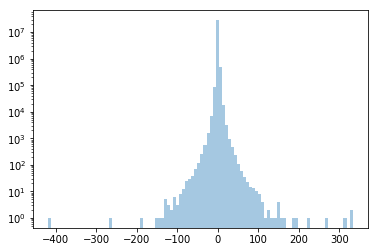

In [202]:
sns.distplot(data3o[triplet_columns].values.ravel(), kde=False, bins=100)
plt.yscale('log')

In [205]:
data3r = data3o.copy()

In [207]:
f3_stats = {}

for c in triplet_columns:
    mean = data3o.loc[is_train, c].mean()
    std = data3o.loc[is_train, c].std()
    f3_stats[c] = [mean, std]
    data3r.loc[:, c] = (data3o[c] - mean) / (std + 1e-12)    

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


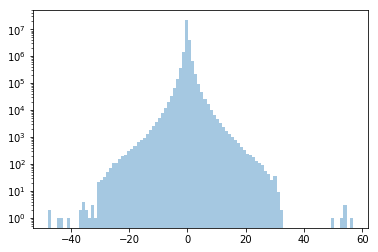

In [208]:
sns.distplot(data3r[triplet_columns].values.ravel(), kde=False, bins=100)
plt.yscale('log')

### Triplet features filtering by model feature importance

In [209]:
cols = triplet_columns
data3 = data3o

In [214]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

n_jobs=1
seed = 42
        
log_reg = LogisticRegression(random_state=seed)
log_reg.fit(data3.loc[is_train, cols], data3.loc[is_train, 'target'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

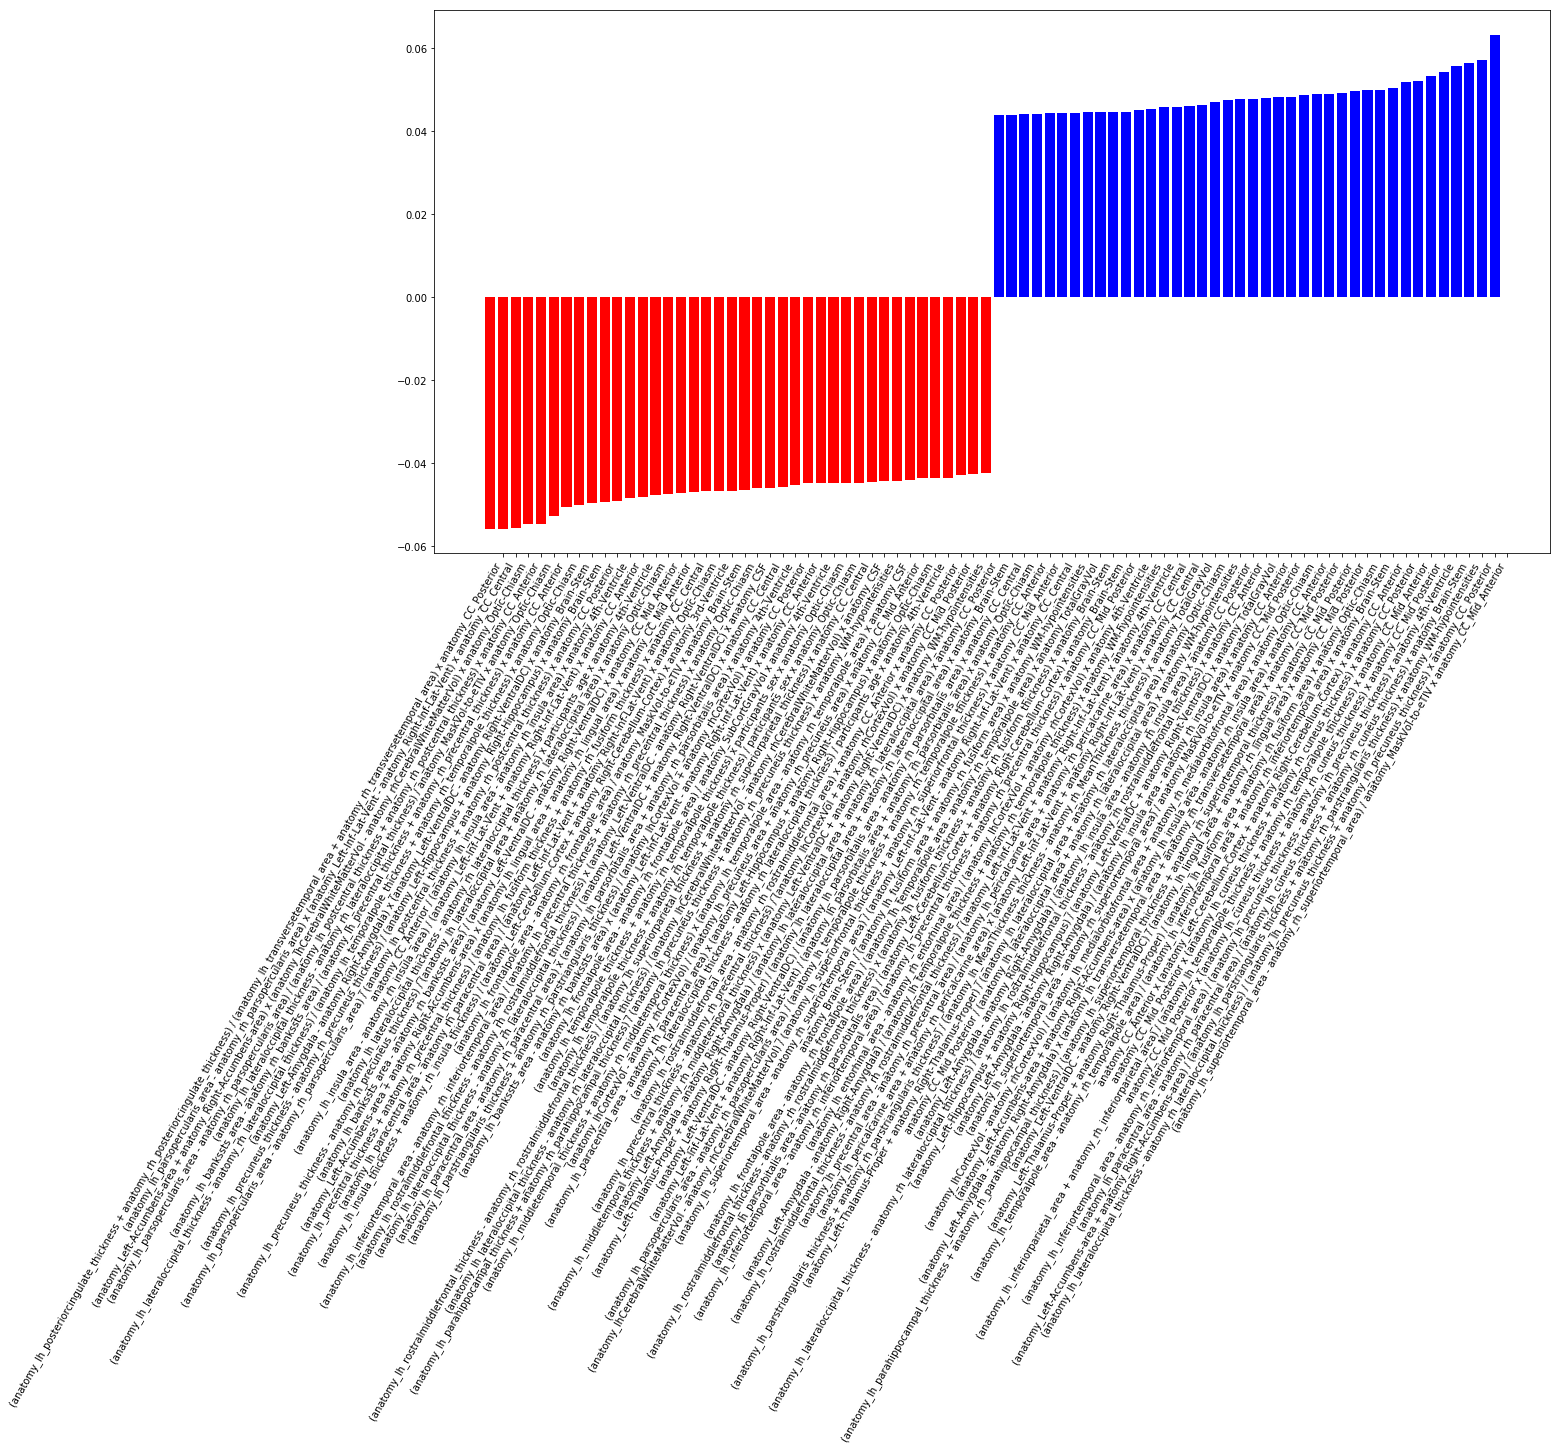

In [215]:
visualize_coefficients(log_reg, feature_names=cols, n_top_features=40)

In [218]:
coef = log_reg.coef_.ravel()

In [219]:
coef.min(), coef.max(), np.abs(coef).min()

(-0.055895282637144196, 0.06318437166052955, 6.065714984470911e-07)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


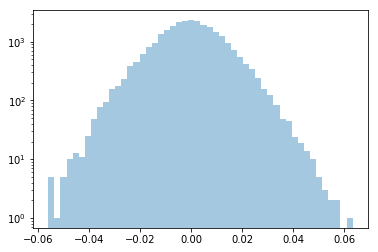

In [220]:
sns.distplot(coef, kde=False)
plt.yscale('log')

In [221]:
from itertools import product

In [222]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold

seed = 90
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(StandardScaler(), 
                                LogisticRegressionCV(n_jobs=8,
                                                     # cv=StratifiedKFold(n_splits=5, random_state=seed),                                                    
                                                     scoring="roc_auc", 
                                                     random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

Grid search

In [223]:
neg_thresholds = np.linspace(-0.01, -0.05, 12)
pos_thresholds = np.linspace(0.01, 0.05, 12)

In [224]:
best_roc = 0.0
best_thresholds = None
max_early_stopping = 30
c = max_early_stopping

for i, (neg_threshold, pos_threshold) in enumerate(product(neg_thresholds, pos_thresholds)):
    print("Trial: ", i, neg_threshold, pos_threshold, end=" -> ")
    positive_coefficients = np.where(coef > pos_threshold)[0]
    negative_coefficients = np.where(coef < neg_threshold)[0]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    top_3_selected_columns = np.array(cols)[interesting_coefficients].tolist()
        
    results = evaluation(data3.loc[is_train, top_3_selected_columns], data3.loc[is_train, 'target'], verbose=False)
    
    current_roc = np.mean(results['test_roc_auc'])
    print(current_roc)
    c -= 1
    if current_roc > best_roc:
        best_thresholds = (neg_threshold, pos_threshold)
        best_roc = current_roc
        c = max_early_stopping
    
    if c == 0:
        print("Stop by early stopping")
        break

Trial:  0 -0.01 0.01 -> 0.9366879544115795
Trial:  1 -0.01 0.013636363636363637 -> 0.9485973432248992
Trial:  2 -0.01 0.017272727272727273 -> 0.9435310725302566
Trial:  3 -0.01 0.020909090909090912 -> 0.9213041216439232
Trial:  4 -0.01 0.024545454545454544 -> 0.8907569158813662
Trial:  5 -0.01 0.028181818181818183 -> 0.8557189136293276
Trial:  6 -0.01 0.03181818181818182 -> 0.8238052877439467
Trial:  7 -0.01 0.035454545454545454 -> 0.7999524205600508
Trial:  8 -0.01 0.03909090909090909 -> 0.7813942847765443
Trial:  9 -0.01 0.04272727272727273 -> 0.7710286518099231
Trial:  10 -0.01 0.046363636363636364 -> 0.7594288024972162
Trial:  11 -0.01 0.05 -> 0.7532629224658967
Trial:  12 -0.013636363636363637 0.01 -> 0.9509555628515594
Trial:  13 -0.013636363636363637 0.013636363636363637 -> 0.9654268435870648
Trial:  14 -0.013636363636363637 0.017272727272727273 -> 0.9687534346588162
Trial:  15 -0.013636363636363637 0.020909090909090912 -> 0.9531736612563562
Trial:  16 -0.013636363636363637 0.02

Process ForkPoolWorker-25503:
Process ForkPoolWorker-25501:
Process ForkPoolWorker-25500:
Process ForkPoolWorker-25502:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/envs/rampwf/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/conda/envs/rampwf/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/envs/rampwf/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/envs/rampwf/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/envs/rampwf/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/envs/rampwf/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/con

KeyboardInterrupt: 

In [225]:
best_thresholds

(-0.017272727272727273, 0.017272727272727273)

In [226]:
# neg_threshold = 0.27 * coef.min()
# pos_threshold = 0.127 * coef.max()
neg_threshold, pos_threshold = best_thresholds
print(neg_threshold, pos_threshold)

positive_coefficients = np.where(coef > pos_threshold)[0]
negative_coefficients = np.where(coef < neg_threshold)[0]

print(len(negative_coefficients), len(positive_coefficients), len(coef))


interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
top_3_selected_columns = np.array(cols)[interesting_coefficients].tolist()

results = evaluation(data3.loc[is_train, top_3_selected_columns], data3.loc[is_train, 'target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

-0.017272727272727273 0.017272727272727273
2483 2286 28028
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.973 +- 0.007 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.936 +- 0.011



```
-0.017272727272727273 0.017272727272727273
2483 2286 28028
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.973 +- 0.007 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.936 +- 0.011
```

In [227]:
print("[", end="")
for f in top_3_selected_columns:
    print("\"{}\"".format(f), end=", ")
print("]")

["anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_BrainSegVol-to-eTIV", "anatomy_Brain-Stem / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_SubCortGrayVol", "anatomy_Brain-Stem / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Central", "anatomy_Brain-Stem / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_3rd-Ventricle", "anatomy_Brain-Stem / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_4th-Ventricle", "anatomy_Brain-Stem / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "anatomy_Brain-Stem / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "anatomy_Brain-Stem / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_TotalGrayVol", "anatomy_Brain-Stem / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy

, "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Anterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_SubCortGrayVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_MaskVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_MeanThickness_thickness - a

, "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_Brain-Stem", "(anatomy_lhCortexVol + anatomy_rhCortexVol) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_WM-hypointensities", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x participants_sex x anatomy_3rd-Ventricle", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / participants_sex x anatomy_3rd-Ventricle", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / participants_sex x a

In [228]:

f3_columns = ["anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_BrainSegVol-to-eTIV", "anatomy_Brain-Stem / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_SubCortGrayVol", "anatomy_Brain-Stem / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Central", "anatomy_Brain-Stem / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_3rd-Ventricle", "anatomy_Brain-Stem / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_4th-Ventricle", "anatomy_Brain-Stem / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "anatomy_Brain-Stem / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "anatomy_Brain-Stem / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_TotalGrayVol", "anatomy_Brain-Stem / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_3rd-Ventricle", "anatomy_Brain-Stem / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_4th-Ventricle", "anatomy_Brain-Stem / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_4th-Ventricle", "anatomy_Brain-Stem / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_Brain-Stem", "anatomy_Brain-Stem / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_Brain-Stem", "anatomy_Brain-Stem / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Mid_Posterior", "anatomy_Brain-Stem / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Central", "anatomy_Brain-Stem / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Mid_Anterior", "anatomy_Brain-Stem / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Anterior", "anatomy_Brain-Stem / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVolNotVentSurf", "anatomy_Brain-Stem / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_TotalGrayVol", "anatomy_Brain-Stem / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_SupraTentorialVol", "anatomy_Brain-Stem / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_SupraTentorialVolNotVent", "anatomy_Brain-Stem / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_Brain-Stem", "anatomy_Brain-Stem / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Posterior", "anatomy_Brain-Stem / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Anterior", "anatomy_Brain-Stem / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_SubCortGrayVol", "anatomy_Brain-Stem / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "anatomy_Brain-Stem / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Brain-Stem", "anatomy_BrainSegVol / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_Brain-Stem", "anatomy_BrainSegVol / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_Optic-Chiasm", "anatomy_BrainSegVol / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_SubCortGrayVol", "anatomy_BrainSegVol / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_CC_Posterior", "anatomy_BrainSegVol / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Posterior", "anatomy_BrainSegVol x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_WM-hypointensities", "anatomy_MaskVol / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_4th-Ventricle", "anatomy_BrainSegVolNotVent / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_Brain-Stem", "anatomy_BrainSegVolNotVent / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_Optic-Chiasm", "anatomy_BrainSegVolNotVent / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_SubCortGrayVol", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_Brain-Stem", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_eTIV", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_CC_Central", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_SubCortGrayVol", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_TotalGrayVol", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CSF", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_3rd-Ventricle x anatomy_WM-hypointensities", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_3rd-Ventricle x anatomy_Optic-Chiasm", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_3rd-Ventricle x anatomy_CC_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_CC_Anterior x anatomy_Brain-Stem", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_Brain-Stem", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Brain-Stem", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_3rd-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Mid_Posterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Central", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Mid_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_Brain-Stem", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CSF", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x anatomy_CC_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x anatomy_eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_Brain-Stem", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_Brain-Stem", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_4th-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_4th-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_TotalGrayVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_Brain-Stem", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_BrainSegVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Brain-Stem", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x anatomy_CSF", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CSF", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_CC_Mid_Posterior x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / anatomy_CC_Mid_Posterior x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_MaskVol-to-eTIV x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / anatomy_3rd-Ventricle x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / anatomy_3rd-Ventricle x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / anatomy_3rd-Ventricle x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / anatomy_3rd-Ventricle x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CSF", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x participants_age x anatomy_4th-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_TotalGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Central", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_SubCortGrayVol x anatomy_4th-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_SubCortGrayVol x anatomy_Optic-Chiasm", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_SubCortGrayVol x anatomy_CC_Central", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_SubCortGrayVol x anatomy_eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CSF", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_WM-hypointensities", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Central", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Central", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_CSF", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Anterior x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Anterior x anatomy_CC_Central", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Anterior x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Anterior x anatomy_TotalGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_Brain-Stem", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CSF", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Brain-Stem", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_TotalGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_SupraTentorialVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CSF", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SubCortGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_eTIV", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / participants_age x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / participants_age x anatomy_TotalGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / participants_age x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CSF x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CSF x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CSF x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Mid_Posterior x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x participants_age x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x participants_age x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / participants_age x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_Brain-Stem", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_SubCortGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_SupraTentorialVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_TotalGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior x anatomy_Brain-Stem", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior x anatomy_CSF", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior x anatomy_BrainSegVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior x anatomy_SubCortGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior x anatomy_TotalGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior x anatomy_SupraTentorialVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior x anatomy_eTIV", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior x anatomy_BrainSegVolNotVent", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Brain-Stem", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CSF", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x participants_sex x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x participants_sex x anatomy_CC_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / participants_sex x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / participants_sex x anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_WM-hypointensities", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Central", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CSF", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Central", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Central", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / anatomy_CC_Anterior x anatomy_WM-hypointensities", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Central", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_Brain-Stem", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / participants_age x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_eTIV", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_CC_Mid_Posterior x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CC_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CSF", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_CC_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_TotalGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_Brain-Stem", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_BrainSegVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_SubCortGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_TotalGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_eTIV", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_BrainSegVolNotVent", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CSF", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Central", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_BrainSegVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_TotalGrayVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_BrainSegVolNotVent", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Anterior x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Anterior x anatomy_4th-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Anterior x anatomy_Brain-Stem", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Anterior x anatomy_CSF", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Anterior x anatomy_CC_Central", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Anterior x anatomy_CC_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / anatomy_CC_Anterior x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / anatomy_CC_Anterior x anatomy_Brain-Stem", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / anatomy_CC_Anterior x anatomy_CSF", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / anatomy_CC_Anterior x anatomy_SubCortGrayVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Brain-Stem", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_Brain-Stem", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_Brain-Stem", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Central", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x participants_age x anatomy_CC_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x participants_age x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_TotalGrayVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_SupraTentorialVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Mid_Posterior x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_TotalGrayVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_SupraTentorialVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_TotalGrayVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_TotalGrayVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_TotalGrayVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x participants_age x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Posterior x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age x anatomy_eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_Optic-Chiasm", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_4th-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_Brain-Stem", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_3rd-Ventricle x anatomy_3rd-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_3rd-Ventricle x anatomy_Brain-Stem", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_3rd-Ventricle x anatomy_WM-hypointensities", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Mid_Posterior x anatomy_CSF", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Mid_Posterior x anatomy_Optic-Chiasm", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Mid_Posterior x anatomy_CC_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_SubCortGrayVol x anatomy_Optic-Chiasm", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Central", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_Brain-Stem", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CSF", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x participants_sex x anatomy_CC_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / participants_sex x anatomy_CC_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_Brain-Stem", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_Brain-Stem", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_CC_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Central", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_TotalGrayVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Anterior x anatomy_eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_Brain-Stem", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Brain-Stem", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Optic-Chiasm", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_3rd-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Brain-Stem", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CSF", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_SubCortGrayVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_SupraTentorialVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CSF", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Central", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Central", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_CC_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_TotalGrayVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_3rd-Ventricle", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_TotalGrayVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Central", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_TotalGrayVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Central", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_BrainSegVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_TotalGrayVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_SupraTentorialVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_eTIV", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_BrainSegVolNotVent", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_sex x anatomy_Optic-Chiasm", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / participants_sex x anatomy_Optic-Chiasm", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_age x anatomy_Brain-Stem", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_age x anatomy_Optic-Chiasm", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_WM-hypointensities", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CSF", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Anterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x participants_age x anatomy_Brain-Stem", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x participants_age x anatomy_Optic-Chiasm", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x participants_age x anatomy_CC_Posterior", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_CC_Posterior", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_CC_Central", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / anatomy_3rd-Ventricle x anatomy_CC_Posterior", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_WM-hypointensities", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Anterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_3rd-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / anatomy_CC_Mid_Posterior x anatomy_3rd-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Posterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_SubCortGrayVol", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x participants_sex x anatomy_CC_Anterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / participants_sex x anatomy_CC_Anterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_TotalGrayVol", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_Brain-Stem", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_CC_Mid_Posterior x anatomy_4th-Ventricle", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_CC_Mid_Posterior x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CSF", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_4th-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Mid_Anterior x anatomy_CC_Posterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Anterior x anatomy_3rd-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_4th-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_BrainSegVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_SubCortGrayVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_TotalGrayVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_eTIV", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_BrainSegVolNotVent", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_eTIV", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_eTIV", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / anatomy_CC_Mid_Anterior x anatomy_4th-Ventricle", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / anatomy_CC_Mid_Anterior x anatomy_Optic-Chiasm", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Central", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Posterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_4th-Ventricle", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Central", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SubCortGrayVol", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SubCortGrayVol", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_TotalGrayVol", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_eTIV", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_CC_Mid_Posterior x anatomy_Optic-Chiasm", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_CC_Mid_Posterior x anatomy_CC_Central", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_CC_Mid_Posterior x anatomy_CC_Mid_Anterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_CC_Mid_Posterior x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Anterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CSF", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_eTIV", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_SubCortGrayVol x anatomy_Brain-Stem", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_SubCortGrayVol x anatomy_WM-hypointensities", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_SubCortGrayVol x anatomy_CC_Central", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_4th-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CSF", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_3rd-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Brain-Stem", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_4th-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Brain-Stem", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Optic-Chiasm", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_eTIV", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_TotalGrayVol", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_Optic-Chiasm", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Brain-Stem", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_Brain-Stem", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x participants_sex x anatomy_WM-hypointensities", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / participants_sex x anatomy_WM-hypointensities", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x participants_age x anatomy_CC_Central", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_3rd-Ventricle x anatomy_Brain-Stem", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_3rd-Ventricle x anatomy_eTIV", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Posterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / participants_age x anatomy_WM-hypointensities", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_Brain-Stem", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_WM-hypointensities", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_SubCortGrayVol x anatomy_CC_Anterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CSF", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_Optic-Chiasm", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Anterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_TotalGrayVol", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_eTIV", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / participants_age x anatomy_CSF", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_4th-Ventricle", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Anterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / anatomy_CSF x anatomy_3rd-Ventricle", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / anatomy_CSF x anatomy_Brain-Stem", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_CSF", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_CC_Anterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / anatomy_CC_Anterior x anatomy_3rd-Ventricle", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / anatomy_CC_Anterior x anatomy_4th-Ventricle", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_3rd-Ventricle", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_4th-Ventricle", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Brain-Stem", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CSF", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Optic-Chiasm", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Central", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_4th-Ventricle", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Posterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Posterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Central", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Anterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CSF", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Central", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Central", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_SubCortGrayVol", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_Brain-Stem", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_WM-hypointensities", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_CC_Anterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_eTIV", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_Brain-Stem", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x participants_age x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / participants_age x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / participants_age x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Mid_Posterior x anatomy_CSF", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Mid_Posterior x anatomy_CC_Central", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / anatomy_CC_Mid_Posterior x anatomy_CSF", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / anatomy_CC_Mid_Posterior x anatomy_CC_Central", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / anatomy_CC_Mid_Posterior x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / anatomy_CC_Anterior x anatomy_3rd-Ventricle", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / anatomy_CC_Anterior x anatomy_4th-Ventricle", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_Brain-Stem", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_4th-Ventricle", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_Brain-Stem", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CSF", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Posterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_4th-Ventricle", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CSF", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Central", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Posterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "anatomy_3rd-Ventricle x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Mid_Anterior", "anatomy_3rd-Ventricle / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_3rd-Ventricle", "anatomy_3rd-Ventricle x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_WM-hypointensities", "anatomy_3rd-Ventricle x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Posterior", "anatomy_3rd-Ventricle x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_WM-hypointensities", "anatomy_3rd-Ventricle x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Mid_Posterior", "anatomy_3rd-Ventricle x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Central", "anatomy_3rd-Ventricle x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Mid_Anterior", "anatomy_3rd-Ventricle x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_SubCortGrayVol", "anatomy_3rd-Ventricle x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_eTIV", "anatomy_CC_Mid_Posterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Posterior", "anatomy_CC_Mid_Posterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Posterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Central", "anatomy_CC_Mid_Posterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Mid_Anterior", "anatomy_CC_Mid_Posterior x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Brain-Stem", "anatomy_CC_Mid_Posterior / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Anterior", "anatomy_CC_Mid_Posterior x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVolNotVentSurf", "anatomy_CC_Mid_Posterior x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_TotalGrayVol", "anatomy_CC_Mid_Posterior x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVol", "anatomy_CC_Mid_Posterior x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVolNotVent", "anatomy_CC_Mid_Posterior / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "anatomy_CC_Mid_Posterior x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CSF", "anatomy_CC_Mid_Posterior x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CSF", "anatomy_CC_Mid_Posterior / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Anterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Posterior", "anatomy_CC_Mid_Anterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Anterior x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "anatomy_CC_Mid_Anterior x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVolNotVentSurf", "anatomy_CC_Mid_Anterior x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVol", "anatomy_CC_Mid_Anterior x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVolNotVent", "anatomy_CC_Mid_Anterior x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_3rd-Ventricle", "anatomy_CC_Mid_Anterior x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_WM-hypointensities", "anatomy_CC_Mid_Anterior x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Anterior x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Central", "anatomy_CC_Mid_Anterior x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Anterior", "anatomy_CC_Mid_Anterior x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "anatomy_CC_Mid_Anterior / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Optic-Chiasm", "anatomy_CC_Mid_Anterior / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Mid_Anterior", "anatomy_CC_Mid_Anterior x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_4th-Ventricle", "anatomy_CC_Mid_Anterior x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_3rd-Ventricle", "anatomy_CC_Mid_Anterior x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_4th-Ventricle", "anatomy_CC_Anterior / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Anterior", "anatomy_CC_Anterior / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Anterior", "anatomy_CC_Anterior x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "anatomy_CC_Anterior / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_eTIV", "anatomy_CC_Anterior / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_Brain-Stem", "anatomy_CC_Anterior / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_Optic-Chiasm", "anatomy_CC_Anterior / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Posterior", "anatomy_CC_Anterior / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "anatomy_CC_Anterior x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "anatomy_CC_Anterior x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CSF", "anatomy_MaskVol-to-eTIV / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Brain-Stem", "anatomy_MaskVol-to-eTIV / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Posterior", "anatomy_MaskVol-to-eTIV / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_Optic-Chiasm", "anatomy_MaskVol-to-eTIV / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "anatomy_MaskVol-to-eTIV / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_Brain-Stem", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_Brain-Stem", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CSF", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_eTIV", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_4th-Ventricle", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_TotalGrayVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CSF", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_Brain-Stem", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Anterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_eTIV", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CSF", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Central", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_WM-hypointensities", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CSF", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CSF", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_WM-hypointensities", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SubCortGrayVol", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Brain-Stem", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_4th-Ventricle", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CSF", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_Brain-Stem", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_Optic-Chiasm", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Mid_Posterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CSF", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_4th-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Central", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Brain-Stem", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_SubCortGrayVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_4th-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_SubCortGrayVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_SupraTentorialVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_Brain-Stem", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_3rd-Ventricle", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_4th-Ventricle", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Brain-Stem", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Optic-Chiasm", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Posterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Anterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_eTIV", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Posterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_TotalGrayVol", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Posterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Central", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CSF", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Central", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Anterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_WM-hypointensities", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Posterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Posterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Central", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Central", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_eTIV", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Brain-Stem", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Posterior", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CSF", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Central", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Anterior", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_WM-hypointensities", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Posterior", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Central", "(anatomy_lhCortexVol + anatomy_rhCortexVol) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lhCortexVol + anatomy_rhCortexVol) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Posterior", "(anatomy_lhCortexVol + anatomy_rhCortexVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_3rd-Ventricle", "(anatomy_lhCortexVol + anatomy_rhCortexVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Posterior", "(anatomy_lhCortexVol + anatomy_rhCortexVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Anterior", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Posterior", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Anterior", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Anterior", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_Brain-Stem", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CSF", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CSF", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Brain-Stem", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "anatomy_Brain-Stem x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_3rd-Ventricle", "anatomy_Brain-Stem x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_4th-Ventricle", "anatomy_Brain-Stem x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_SubCortGrayVol", "anatomy_Brain-Stem / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_Brain-Stem", "anatomy_Brain-Stem / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Posterior", "anatomy_Brain-Stem / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Mid_Posterior", "anatomy_Brain-Stem / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_WM-hypointensities", "anatomy_Brain-Stem / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_TotalGrayVol", "anatomy_Brain-Stem / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Optic-Chiasm", "anatomy_Brain-Stem x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_WM-hypointensities", "anatomy_Brain-Stem / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_4th-Ventricle", "anatomy_Brain-Stem / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Anterior", "anatomy_Brain-Stem / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_4th-Ventricle", "anatomy_Brain-Stem x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_4th-Ventricle", "anatomy_BrainSegVol / (anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x anatomy_Optic-Chiasm", "anatomy_BrainSegVol / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_Optic-Chiasm", "anatomy_BrainSegVol x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "anatomy_MaskVol / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_WM-hypointensities", "anatomy_BrainSegVolNotVent / (anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x anatomy_Optic-Chiasm", "anatomy_BrainSegVolNotVent / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_Optic-Chiasm", "anatomy_BrainSegVolNotVent x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x anatomy_3rd-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x anatomy_CSF", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_Optic-Chiasm", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_SubCortGrayVol", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Central", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CSF", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Optic-Chiasm", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Posterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_4th-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Central", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_MaskVol", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_WM-hypointensities", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_Brain-Stem", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Posterior x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Posterior x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Posterior x anatomy_TotalGrayVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Posterior x anatomy_SupraTentorialVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Posterior x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Posterior x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x anatomy_CC_Anterior x anatomy_Brain-Stem", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x anatomy_CC_Anterior x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x anatomy_CC_Anterior x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x anatomy_CC_Anterior x anatomy_TotalGrayVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x anatomy_SubCortGrayVol x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_SubCortGrayVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_CSF", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_3rd-Ventricle x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CSF", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Mid_Posterior x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Mid_Posterior x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / anatomy_CC_Mid_Posterior x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / anatomy_CC_Mid_Posterior x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / anatomy_CC_Mid_Posterior x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Anterior x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Anterior x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Anterior x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Anterior x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_BrainSegVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_BrainSegVolNotVent", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CSF", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_MaskVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CSF", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_Brain-Stem", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_4th-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CSF", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Central", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_WM-hypointensities", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_SubCortGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_CC_Mid_Posterior x anatomy_3rd-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_CC_Mid_Posterior x anatomy_Brain-Stem", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_CC_Mid_Posterior x anatomy_CC_Central", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_CC_Mid_Posterior x anatomy_BrainSegVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_CC_Mid_Posterior x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_CC_Mid_Posterior x anatomy_TotalGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_CC_Mid_Posterior x anatomy_SupraTentorialVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_CC_Mid_Posterior x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_CC_Mid_Posterior x anatomy_BrainSegVolNotVent", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_3rd-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_4th-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_Brain-Stem", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_CSF", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_Optic-Chiasm", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_CC_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_BrainSegVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_SubCortGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_TotalGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_SupraTentorialVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_MaskVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_BrainSegVolNotVent", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_WM-hypointensities", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_WM-hypointensities", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Mid_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Central", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_SubCortGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_TotalGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_SupraTentorialVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_WM-hypointensities", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_WM-hypointensities", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_SubCortGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_WM-hypointensities", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Central", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_Brain-Stem", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Central", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_eTIV", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_Brain-Stem", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Central", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_WM-hypointensities", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_3rd-Ventricle x anatomy_Brain-Stem", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_3rd-Ventricle x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_3rd-Ventricle x anatomy_BrainSegVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_3rd-Ventricle x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_3rd-Ventricle x anatomy_SupraTentorialVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_3rd-Ventricle x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_3rd-Ventricle x anatomy_MaskVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_3rd-Ventricle x anatomy_BrainSegVolNotVent", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CSF x anatomy_WM-hypointensities", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CSF x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CSF x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Mid_Anterior x anatomy_3rd-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Mid_Anterior x anatomy_4th-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Mid_Anterior x anatomy_Brain-Stem", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Mid_Anterior x anatomy_CSF", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Mid_Anterior x anatomy_WM-hypointensities", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Mid_Anterior x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Mid_Anterior x anatomy_CC_Central", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Mid_Anterior x anatomy_SubCortGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Mid_Anterior x anatomy_MaskVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Mid_Anterior x anatomy_eTIV", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_CC_Anterior x anatomy_4th-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_CC_Anterior x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_BrainSegVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_SupraTentorialVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_MaskVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_eTIV", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_BrainSegVolNotVent", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_Brain-Stem", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_BrainSegVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_MaskVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_eTIV", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_TotalGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_SupraTentorialVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_TotalGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CSF x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CSF x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Mid_Anterior x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior x anatomy_eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Anterior x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Anterior x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Anterior x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Anterior x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Anterior x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_SubCortGrayVol x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_SubCortGrayVol x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_SubCortGrayVol x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_SubCortGrayVol x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_MaskVol-to-eTIV x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_MaskVol-to-eTIV x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_MaskVol-to-eTIV x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_MaskVol-to-eTIV x anatomy_MaskVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_MaskVol-to-eTIV x anatomy_eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_BrainSegVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_SupraTentorialVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_BrainSegVolNotVent", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Central", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Anterior x anatomy_eTIV", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CSF", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CSF", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_Optic-Chiasm", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Central", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_Brain-Stem", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Central", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_3rd-Ventricle x anatomy_Brain-Stem", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_3rd-Ventricle x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CSF", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_Optic-Chiasm", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Optic-Chiasm", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CSF", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Central", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SubCortGrayVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CSF", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_BrainSegVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_MaskVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_BrainSegVolNotVent", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_MaskVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_BrainSegVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SubCortGrayVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_eTIV", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_BrainSegVolNotVent", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_MaskVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_MaskVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CSF", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_BrainSegVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_MaskVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_Brain-Stem", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_eTIV", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_WM-hypointensities", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_Optic-Chiasm", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_CC_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_4th-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_4th-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CSF", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_TotalGrayVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CSF", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_eTIV", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_WM-hypointensities", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_Optic-Chiasm", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_BrainSegVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_SubCortGrayVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_TotalGrayVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_SupraTentorialVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_BrainSegVolNotVent", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_Optic-Chiasm", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_MaskVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CSF", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_MaskVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Mid_Anterior x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Mid_Anterior x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Mid_Anterior x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Mid_Anterior x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Mid_Anterior x anatomy_MaskVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Anterior x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Anterior x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Anterior x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Anterior x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Anterior x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_CC_Anterior x anatomy_3rd-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_CC_Anterior x anatomy_WM-hypointensities", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_MaskVol-to-eTIV x anatomy_TotalGrayVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_MaskVol-to-eTIV x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_WM-hypointensities", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_TotalGrayVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_3rd-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_SubCortGrayVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CSF", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_3rd-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_SubCortGrayVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_TotalGrayVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / anatomy_3rd-Ventricle x anatomy_CC_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / anatomy_3rd-Ventricle x anatomy_CC_Mid_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / anatomy_3rd-Ventricle x anatomy_CC_Mid_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / anatomy_3rd-Ventricle x anatomy_CC_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CSF", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / anatomy_CC_Mid_Posterior x anatomy_Brain-Stem", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / anatomy_CC_Mid_Posterior x anatomy_Optic-Chiasm", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / anatomy_CC_Mid_Posterior x anatomy_SupraTentorialVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / anatomy_CC_Mid_Posterior x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Mid_Anterior x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Anterior x anatomy_TotalGrayVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_TotalGrayVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_WM-hypointensities", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_Brain-Stem", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_TotalGrayVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SupraTentorialVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_TotalGrayVol", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_CC_Anterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_TotalGrayVol", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_Brain-Stem", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_SubCortGrayVol", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_TotalGrayVol", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_SupraTentorialVol", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_Brain-Stem", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_3rd-Ventricle", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CSF", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Central", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Anterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_3rd-Ventricle", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_4th-Ventricle", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_BrainSegVol", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_eTIV", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / anatomy_3rd-Ventricle x anatomy_WM-hypointensities", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / anatomy_3rd-Ventricle x anatomy_CC_Anterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_TotalGrayVol", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Brain-Stem", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_WM-hypointensities", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_eTIV", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_3rd-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_4th-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Central", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVol", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVol", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_MaskVol", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_eTIV", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVent", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_Brain-Stem", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Central", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CSF", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_3rd-Ventricle x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_CSF x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_CSF x anatomy_SubCortGrayVol", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CC_Central", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_Brain-Stem", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_SubCortGrayVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CSF x anatomy_3rd-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CSF x anatomy_Brain-Stem", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CSF x anatomy_CC_Mid_Posterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CSF", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_4th-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CSF", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_SubCortGrayVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_MaskVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / participants_age x anatomy_4th-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Posterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Anterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_SubCortGrayVol", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_eTIV", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_eTIV", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_MaskVol", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Central", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_4th-Ventricle", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_Optic-Chiasm", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Central", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Anterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_MaskVol", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Optic-Chiasm", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_4th-Ventricle", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CSF", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SubCortGrayVol", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_MaskVol", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CSF", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_WM-hypointensities", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_CSF x anatomy_Brain-Stem", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_CSF x anatomy_CC_Mid_Posterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_CSF x anatomy_CC_Mid_Anterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_CSF x anatomy_CC_Anterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_CSF x anatomy_SubCortGrayVol", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_CSF x anatomy_MaskVol", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_CSF x anatomy_MaskVol-to-eTIV", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_3rd-Ventricle", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CSF", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Brain-Stem", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CSF", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_4th-Ventricle", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_3rd-Ventricle x anatomy_WM-hypointensities", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_3rd-Ventricle x anatomy_CC_Central", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_CC_Mid_Posterior x anatomy_WM-hypointensities", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_CC_Mid_Posterior x anatomy_CC_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_CC_Mid_Posterior x anatomy_SupraTentorialVol", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_CC_Mid_Posterior x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Anterior x anatomy_Brain-Stem", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Anterior x anatomy_Optic-Chiasm", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Anterior x anatomy_CC_Mid_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Anterior x anatomy_CC_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_CC_Anterior x anatomy_Brain-Stem", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_CC_Anterior x anatomy_Optic-Chiasm", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_CC_Anterior x anatomy_eTIV", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_MaskVol-to-eTIV x anatomy_3rd-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_MaskVol-to-eTIV x anatomy_CSF", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_3rd-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_4th-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_WM-hypointensities", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CSF", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Central", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_3rd-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CSF", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_CC_Mid_Posterior x anatomy_CC_Central", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_CC_Mid_Posterior x anatomy_CC_Mid_Anterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_CC_Mid_Posterior x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_SubCortGrayVol x anatomy_3rd-Ventricle", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_SubCortGrayVol x anatomy_CSF", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_SubCortGrayVol x anatomy_Optic-Chiasm", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_SubCortGrayVol x anatomy_CC_Mid_Anterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_Brain-Stem", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Posterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_MaskVol", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Central", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_3rd-Ventricle x anatomy_4th-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_Brain-Stem", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_Optic-Chiasm", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_TotalGrayVol", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_eTIV", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Posterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / anatomy_3rd-Ventricle x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / anatomy_CSF x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / anatomy_CSF x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / anatomy_CSF x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVol", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_MaskVol", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_eTIV", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVent", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_BrainSegVol", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_SubCortGrayVol", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_BrainSegVolNotVent", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_MaskVol-to-eTIV x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_MaskVol-to-eTIV x anatomy_WM-hypointensities", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_3rd-Ventricle", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_4th-Ventricle", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Posterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_BrainSegVol", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_MaskVol", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_eTIV", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVolNotVent", "anatomy_3rd-Ventricle / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Mid_Anterior", "anatomy_3rd-Ventricle x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_3rd-Ventricle", "anatomy_3rd-Ventricle x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_4th-Ventricle", "anatomy_3rd-Ventricle x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities", "anatomy_3rd-Ventricle / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_Brain-Stem", "anatomy_3rd-Ventricle / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "anatomy_3rd-Ventricle / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Central", "anatomy_3rd-Ventricle x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Posterior", "anatomy_3rd-Ventricle x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Anterior", "anatomy_3rd-Ventricle / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_3rd-Ventricle", "anatomy_3rd-Ventricle / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Brain-Stem", "anatomy_3rd-Ventricle / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Optic-Chiasm", "anatomy_3rd-Ventricle / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_eTIV", "anatomy_CSF / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Central", "anatomy_CSF / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Mid_Anterior", "anatomy_CSF x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_WM-hypointensities", "anatomy_CSF x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_TotalGrayVol", "anatomy_CSF / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_3rd-Ventricle", "anatomy_CSF / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_4th-Ventricle", "anatomy_CSF / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Brain-Stem", "anatomy_CSF / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Central", "anatomy_CSF / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "anatomy_CSF / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_eTIV", "anatomy_CSF / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Posterior", "anatomy_CSF / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Posterior x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_WM-hypointensities", "anatomy_CC_Mid_Posterior x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "anatomy_CC_Mid_Posterior / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "anatomy_CC_Mid_Posterior x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_4th-Ventricle", "anatomy_CC_Mid_Posterior / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_WM-hypointensities", "anatomy_CC_Mid_Posterior / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_3rd-Ventricle", "anatomy_CC_Mid_Posterior / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_Brain-Stem", "anatomy_CC_Mid_Posterior / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CSF", "anatomy_CC_Mid_Anterior / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Posterior", "anatomy_CC_Anterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_4th-Ventricle", "anatomy_CC_Anterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_WM-hypointensities", "anatomy_CC_Anterior / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "anatomy_CC_Anterior / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "anatomy_CC_Anterior / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "anatomy_CC_Anterior / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "anatomy_CC_Anterior / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_3rd-Ventricle", "anatomy_CC_Anterior / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_4th-Ventricle", "anatomy_CC_Anterior / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Posterior", "anatomy_CC_Anterior / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Mid_Posterior", "anatomy_CC_Anterior / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Central", "anatomy_CC_Anterior / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Anterior", "anatomy_CC_Anterior x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_WM-hypointensities", "anatomy_CC_Anterior x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_Optic-Chiasm", "anatomy_CC_Anterior / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Mid_Anterior", "anatomy_SubCortGrayVol / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Optic-Chiasm", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities"

, "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Anterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_SubCortGrayVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_MaskVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Central", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_TotalGrayVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CSF", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Anterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_WM-hypointensities", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x participants_sex x anatomy_WM-hypointensities", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x participants_sex x anatomy_Optic-Chiasm", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x participants_sex x anatomy_CC_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x participants_sex x anatomy_CC_Mid_Anterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / participants_sex x anatomy_WM-hypointensities", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / participants_sex x anatomy_Optic-Chiasm", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / participants_sex x anatomy_CC_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / participants_sex x anatomy_CC_Mid_Anterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / participants_age x anatomy_CC_Posterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Brain-Stem", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Optic-Chiasm", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Posterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Central", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CSF", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_WM-hypointensities", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_MaskVol", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_WM-hypointensities", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Central", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_Optic-Chiasm", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_3rd-Ventricle", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CSF", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Brain-Stem", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_3rd-Ventricle", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_WM-hypointensities", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_CC_Posterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_CC_Central", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_CC_Mid_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_CC_Posterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_CC_Central", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_CC_Mid_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_age x anatomy_CC_Mid_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_age x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_age x anatomy_MaskVol-to-eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_4th-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_4th-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_WM-hypointensities", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Central", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Posterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_4th-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CSF", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_WM-hypointensities", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_SubCortGrayVol", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x participants_sex x anatomy_Optic-Chiasm", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / participants_sex x anatomy_Optic-Chiasm", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x participants_age x anatomy_4th-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x participants_age x anatomy_Optic-Chiasm", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x participants_age x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / participants_age x anatomy_4th-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / participants_age x anatomy_CC_Posterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / participants_age x anatomy_CC_Anterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / participants_age x anatomy_BrainSegVol-to-eTIV", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Anterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_eTIV", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_3rd-Ventricle", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_Brain-Stem", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_WM-hypointensities", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_SubCortGrayVol", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Posterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_WM-hypointensities", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Central", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_SubCortGrayVol", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_4th-Ventricle", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_eTIV", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_4th-Ventricle", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_TotalGrayVol", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_Optic-Chiasm", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Mid_Anterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_3rd-Ventricle", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Brain-Stem", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CSF", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Central", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CSF", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Posterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Central", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Anterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_MaskVol", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_eTIV", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_Brain-Stem", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CSF", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_SubCortGrayVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_TotalGrayVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Anterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Anterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Anterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_BrainSegVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_TotalGrayVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SupraTentorialVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_MaskVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_BrainSegVolNotVent", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CSF", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Posterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CSF", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_eTIV", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CSF", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / participants_age x anatomy_3rd-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / participants_age x anatomy_WM-hypointensities", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / participants_age x anatomy_CC_Central", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / participants_age x anatomy_CC_Mid_Anterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Central", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Central", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Anterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_Brain-Stem", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CSF", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CSF", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CSF", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x participants_sex x anatomy_3rd-Ventricle", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x participants_sex x anatomy_4th-Ventricle", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / participants_sex x anatomy_3rd-Ventricle", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / participants_sex x anatomy_4th-Ventricle", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Central", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CSF", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_MaskVol", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Brain-Stem", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Central", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Anterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x participants_sex x anatomy_Brain-Stem", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x participants_sex x anatomy_WM-hypointensities", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x participants_sex x anatomy_SubCortGrayVol", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / participants_sex x anatomy_Brain-Stem", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / participants_sex x anatomy_WM-hypointensities", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / participants_sex x anatomy_SubCortGrayVol", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Central", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Anterior", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Central", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_3rd-Ventricle", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Anterior", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Posterior", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Central", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Anterior", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CSF", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Central", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SubCortGrayVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_MaskVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_eTIV", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVent", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x participants_age x anatomy_3rd-Ventricle", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x participants_age x anatomy_WM-hypointensities", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x participants_age x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / participants_age x anatomy_3rd-Ventricle", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / participants_age x anatomy_4th-Ventricle", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / participants_age x anatomy_CSF", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / participants_age x anatomy_CC_Mid_Anterior", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / participants_age x anatomy_MaskVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / participants_age x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_age x anatomy_WM-hypointensities", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_age x anatomy_SubCortGrayVol", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_age x anatomy_CC_Mid_Posterior", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_age x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_age x anatomy_SupraTentorialVol", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x participants_age x anatomy_3rd-Ventricle", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x participants_age x anatomy_4th-Ventricle", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x participants_age x anatomy_Brain-Stem", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x participants_age x anatomy_Optic-Chiasm", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x participants_age x anatomy_CC_Posterior", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x participants_age x anatomy_SubCortGrayVol", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x participants_age x anatomy_MaskVol", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x participants_age x anatomy_MaskVol-to-eTIV", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / participants_age x anatomy_3rd-Ventricle", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / participants_age x anatomy_4th-Ventricle", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / participants_age x anatomy_Brain-Stem", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / participants_age x anatomy_CSF", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / participants_age x anatomy_CC_Posterior", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / participants_age x anatomy_SubCortGrayVol", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / participants_age x anatomy_MaskVol", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / participants_age x anatomy_eTIV", "(anatomy_lhCortexVol + anatomy_rhCortexVol) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lhCortexVol + anatomy_rhCortexVol) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_Optic-Chiasm", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_3rd-Ventricle", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Posterior", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_eTIV", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x participants_sex x anatomy_CC_Posterior", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / participants_sex x anatomy_CC_Posterior", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_WM-hypointensities", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_age x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_MaskVol", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_eTIV", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_MaskVol", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_eTIV", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x participants_sex x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x participants_sex x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / participants_sex x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / participants_sex x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / participants_age x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / participants_age x anatomy_MaskVol-to-eTIV", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_MaskVol", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_eTIV", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CSF", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x participants_age x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x participants_age x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / participants_age x anatomy_CSF", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CSF", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_BrainSegVol", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x participants_age x anatomy_WM-hypointensities", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x participants_age x anatomy_TotalGrayVol", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / participants_age x anatomy_WM-hypointensities", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CSF", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Posterior", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CSF", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / participants_age x anatomy_CSF", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CSF", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_sex x anatomy_BrainSegVol", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_sex x anatomy_MaskVol", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_sex x anatomy_BrainSegVolNotVent", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_sex x anatomy_BrainSegVol", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_sex x anatomy_MaskVol", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_sex x anatomy_BrainSegVolNotVent", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x participants_sex x anatomy_3rd-Ventricle", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x participants_sex x anatomy_Brain-Stem", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x participants_sex x anatomy_eTIV", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) / participants_sex x anatomy_3rd-Ventricle", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) / participants_sex x anatomy_Brain-Stem", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) / participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) / participants_sex x anatomy_eTIV", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x participants_age x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x participants_age x anatomy_MaskVol-to-eTIV", "anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_4th-Ventricle", "anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_Brain-Stem", "anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_CSF", "anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_Optic-Chiasm", "anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_CC_Posterior", "anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_CC_Central", "anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_CC_Anterior", "anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_eTIV", "anatomy_Brain-Stem / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm", "anatomy_Brain-Stem / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_4th-Ventricle", "anatomy_Brain-Stem / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_3rd-Ventricle", "anatomy_Brain-Stem / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_CSF", "anatomy_Brain-Stem / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_WM-hypointensities", "anatomy_Brain-Stem / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_Optic-Chiasm", "anatomy_Brain-Stem / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_BrainSegVol-to-eTIV", "anatomy_Brain-Stem / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_4th-Ventricle", "anatomy_Brain-Stem / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Anterior", "anatomy_Brain-Stem / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Posterior", "anatomy_Brain-Stem / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Brain-Stem", "anatomy_Brain-Stem / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Posterior", "anatomy_Brain-Stem / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Anterior", "anatomy_Brain-Stem x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_WM-hypointensities", "anatomy_BrainSegVol x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_TotalGrayVol", "anatomy_MaskVol / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Anterior", "anatomy_MaskVol x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_Brain-Stem", "anatomy_MaskVol x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Central", "anatomy_MaskVol x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_eTIV", "anatomy_BrainSegVolNotVent x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Central", "anatomy_BrainSegVolNotVent x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_TotalGrayVol", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_CC_Posterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_3rd-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_Optic-Chiasm", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Posterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Central", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_Optic-Chiasm", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Posterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_3rd-Ventricle x anatomy_CC_Central", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_CC_Mid_Posterior x anatomy_WM-hypointensities", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_CC_Anterior x anatomy_CC_Mid_Posterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_CC_Anterior x anatomy_CC_Central", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_CC_Anterior x anatomy_CC_Mid_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_CC_Anterior x anatomy_SupraTentorialVol", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_CC_Anterior x anatomy_SupraTentorialVolNotVent", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_CC_Anterior x anatomy_MaskVol", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_CC_Anterior x anatomy_MaskVol-to-eTIV", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Brain-Stem", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_3rd-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_Brain-Stem", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SubCortGrayVol", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CSF", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_MaskVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_CC_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_Optic-Chiasm", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Anterior x anatomy_WM-hypointensities", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Anterior x anatomy_CC_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Anterior x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Anterior x anatomy_MaskVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Optic-Chiasm", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_MaskVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_BrainSegVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_MaskVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_CC_Mid_Posterior x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / anatomy_CC_Mid_Posterior x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVolNotVent", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CSF", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_BrainSegVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_BrainSegVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CSF", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_eTIV", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x participants_age x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x participants_age x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / participants_age x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / participants_age x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / participants_age x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / participants_age x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / participants_age x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / participants_age x anatomy_BrainSegVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / participants_age x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / participants_age x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / participants_age x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / participants_age x anatomy_BrainSegVolNotVent", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_SubCortGrayVol x anatomy_CC_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_SubCortGrayVol x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_Brain-Stem", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_SubCortGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CSF", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / participants_age x anatomy_CSF", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / participants_age x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_MaskVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Anterior x anatomy_WM-hypointensities", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Anterior x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_WM-hypointensities", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_Brain-Stem", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Brain-Stem", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x participants_age x anatomy_CSF", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x participants_age x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / participants_age x anatomy_CSF", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / participants_age x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_BrainSegVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_MaskVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Mid_Posterior x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Mid_Posterior x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Mid_Posterior x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_SupraTentorialVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_TotalGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_BrainSegVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_MaskVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x participants_age x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / participants_age x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / participants_age x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / participants_age x anatomy_MaskVol-to-eTIV", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_eTIV", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_TotalGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Brain-Stem", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x participants_sex x anatomy_Brain-Stem", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / participants_sex x anatomy_Brain-Stem", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x participants_age x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x participants_age x anatomy_CC_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x participants_age x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x participants_age x anatomy_SubCortGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x participants_age x anatomy_SupraTentorialVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x participants_age x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_TotalGrayVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_Brain-Stem", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_Brain-Stem", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Anterior x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / anatomy_CC_Anterior x anatomy_CC_Central", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Central", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Central", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_WM-hypointensities", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x participants_age x anatomy_Brain-Stem", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x participants_age x anatomy_CC_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x participants_age x anatomy_SubCortGrayVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / participants_age x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / participants_age x anatomy_Brain-Stem", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / participants_age x anatomy_SubCortGrayVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CSF", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_Brain-Stem", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_Brain-Stem", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_Brain-Stem", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_MaskVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_CC_Mid_Posterior x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_CC_Mid_Posterior x anatomy_CSF", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_CC_Mid_Posterior x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_CC_Mid_Posterior x anatomy_CC_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CSF", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_SubCortGrayVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Brain-Stem", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_Brain-Stem", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_3rd-Ventricle x anatomy_Brain-Stem", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_3rd-Ventricle x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_3rd-Ventricle x anatomy_CC_Central", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_3rd-Ventricle x anatomy_SubCortGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_3rd-Ventricle x anatomy_MaskVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_3rd-Ventricle x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CSF", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CSF", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_SubCortGrayVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Anterior x anatomy_WM-hypointensities", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_WM-hypointensities", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_TotalGrayVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_SupraTentorialVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_WM-hypointensities", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_4th-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Brain-Stem", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Central", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_BrainSegVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_eTIV", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x participants_age x anatomy_4th-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Mid_Posterior x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Mid_Posterior x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x participants_age x anatomy_TotalGrayVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / participants_age x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / participants_age x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_eTIV", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Posterior x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Posterior x anatomy_SubCortGrayVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / anatomy_CC_Mid_Posterior x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / anatomy_CC_Mid_Posterior x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_BrainSegVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_eTIV", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_BrainSegVolNotVent", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_3rd-Ventricle x anatomy_4th-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_3rd-Ventricle x anatomy_CSF", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_SubCortGrayVol x anatomy_WM-hypointensities", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_TotalGrayVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Central", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_CSF", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_WM-hypointensities", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_BrainSegVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_TotalGrayVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_SupraTentorialVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CSF", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Central", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_SubCortGrayVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Anterior x anatomy_Optic-Chiasm", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Anterior x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_4th-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Brain-Stem", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CSF", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_SubCortGrayVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_SupraTentorialVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVolNotVent", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_4th-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_WM-hypointensities", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_4th-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CSF", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Central", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_SubCortGrayVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_CC_Central", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_WM-hypointensities", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_SubCortGrayVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_TotalGrayVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_WM-hypointensities", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Brain-Stem", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Central", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_sex x anatomy_WM-hypointensities", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_sex x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_sex x anatomy_CC_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / participants_sex x anatomy_WM-hypointensities", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / participants_sex x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / participants_sex x anatomy_CC_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_age x anatomy_CC_Anterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_4th-Ventricle", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Central", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Anterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_4th-Ventricle", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x participants_age x anatomy_TotalGrayVol", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / anatomy_3rd-Ventricle x anatomy_4th-Ventricle", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / anatomy_3rd-Ventricle x anatomy_Optic-Chiasm", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Central", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Anterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / anatomy_CC_Mid_Anterior x anatomy_TotalGrayVol", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_MaskVol-to-eTIV x anatomy_3rd-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_MaskVol-to-eTIV x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_MaskVol-to-eTIV x anatomy_TotalGrayVol", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_MaskVol-to-eTIV x anatomy_SupraTentorialVol", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_MaskVol-to-eTIV x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_MaskVol-to-eTIV x anatomy_eTIV", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_TotalGrayVol", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_WM-hypointensities", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Central", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Anterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Anterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_CC_Mid_Posterior x anatomy_Brain-Stem", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_CC_Mid_Posterior x anatomy_Optic-Chiasm", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_CC_Mid_Posterior x anatomy_CC_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_CC_Mid_Posterior x anatomy_SubCortGrayVol", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_CC_Mid_Anterior x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVol", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVol", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_MaskVol", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVent", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_eTIV", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Central", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Anterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x participants_age x anatomy_4th-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_TotalGrayVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CSF", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_WM-hypointensities", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Anterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_eTIV", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Mid_Anterior x anatomy_BrainSegVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Mid_Anterior x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Mid_Anterior x anatomy_TotalGrayVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Mid_Anterior x anatomy_SupraTentorialVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Mid_Anterior x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Mid_Anterior x anatomy_BrainSegVolNotVent", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Anterior x anatomy_4th-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Anterior x anatomy_CC_Central", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Anterior x anatomy_CC_Mid_Anterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Anterior x anatomy_BrainSegVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Anterior x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Anterior x anatomy_SubCortGrayVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Anterior x anatomy_TotalGrayVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Anterior x anatomy_SupraTentorialVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Anterior x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Anterior x anatomy_BrainSegVolNotVent", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_TotalGrayVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Central", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Central", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Central", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / anatomy_CC_Mid_Anterior x anatomy_Brain-Stem", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / anatomy_CC_Mid_Anterior x anatomy_WM-hypointensities", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_BrainSegVol", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_MaskVol-to-eTIV x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_MaskVol-to-eTIV x anatomy_SupraTentorialVol", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_MaskVol-to-eTIV x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_MaskVol-to-eTIV x anatomy_eTIV", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVol", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_eTIV", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Posterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Central", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Central", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CSF", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Central", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_SubCortGrayVol x anatomy_CC_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_Optic-Chiasm", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Central", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CSF", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Central", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_4th-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CSF", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x participants_age x anatomy_3rd-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / participants_age x anatomy_3rd-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / participants_age x anatomy_CC_Mid_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / participants_age x anatomy_CC_Anterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_3rd-Ventricle x anatomy_4th-Ventricle", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_3rd-Ventricle x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_3rd-Ventricle x anatomy_MaskVol-to-eTIV", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CSF", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_WM-hypointensities", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / participants_age x anatomy_3rd-Ventricle", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / participants_age x anatomy_4th-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_SubCortGrayVol x anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_SubCortGrayVol x anatomy_4th-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_eTIV", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CSF", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Central", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_eTIV", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CSF", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x participants_sex x anatomy_CC_Central", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x participants_sex x anatomy_CC_Mid_Anterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / participants_sex x anatomy_CC_Central", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / participants_sex x anatomy_CC_Mid_Anterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / participants_age x anatomy_Brain-Stem", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / participants_age x anatomy_CC_Central", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Central", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_eTIV", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / anatomy_CSF x anatomy_CC_Central", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / anatomy_CSF x anatomy_TotalGrayVol", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / anatomy_CC_Anterior x anatomy_Brain-Stem", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / anatomy_CC_Anterior x anatomy_CC_Mid_Anterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_SubCortGrayVol", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_TotalGrayVol", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVol", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_SubCortGrayVol", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_TotalGrayVol", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVol", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_MaskVol", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_eTIV", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVolNotVent", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_SubCortGrayVol", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_TotalGrayVol", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_3rd-Ventricle", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CSF", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_Brain-Stem", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Anterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_MaskVol", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Anterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x participants_sex x anatomy_Brain-Stem", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x participants_sex x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x participants_sex x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x participants_sex x anatomy_eTIV", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / participants_sex x anatomy_Brain-Stem", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / participants_sex x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / participants_sex x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / participants_sex x anatomy_eTIV", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_CC_Central", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_TotalGrayVol", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_SubCortGrayVol", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Anterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CSF", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / participants_age x anatomy_3rd-Ventricle", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Mid_Posterior x anatomy_CC_Posterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / anatomy_CC_Mid_Posterior x anatomy_CC_Posterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / anatomy_CC_Anterior x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / anatomy_CC_Anterior x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_TotalGrayVol", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_Optic-Chiasm", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_TotalGrayVol", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_MaskVol", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CSF", "anatomy_3rd-Ventricle x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CSF", "anatomy_3rd-Ventricle x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "anatomy_3rd-Ventricle x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "anatomy_3rd-Ventricle x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_4th-Ventricle", "anatomy_3rd-Ventricle x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_Brain-Stem", "anatomy_3rd-Ventricle x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SubCortGrayVol", "anatomy_3rd-Ventricle x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_eTIV", "anatomy_3rd-Ventricle / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_3rd-Ventricle", "anatomy_3rd-Ventricle / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_4th-Ventricle", "anatomy_3rd-Ventricle / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CSF", "anatomy_3rd-Ventricle / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_Optic-Chiasm", "anatomy_3rd-Ventricle / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_SubCortGrayVol", "anatomy_3rd-Ventricle x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CSF", "anatomy_3rd-Ventricle x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "anatomy_3rd-Ventricle x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVentSurf", "anatomy_3rd-Ventricle x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVol", "anatomy_3rd-Ventricle x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVolNotVent", "anatomy_3rd-Ventricle x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_3rd-Ventricle", "anatomy_3rd-Ventricle x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_Optic-Chiasm", "anatomy_3rd-Ventricle x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_Optic-Chiasm", "anatomy_3rd-Ventricle x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_BrainSegVol-to-eTIV", "anatomy_CSF x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_Brain-Stem", "anatomy_CSF x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Mid_Posterior", "anatomy_CSF x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SubCortGrayVol", "anatomy_CSF x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Posterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_3rd-Ventricle", "anatomy_CC_Mid_Posterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_4th-Ventricle", "anatomy_CC_Mid_Posterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_Optic-Chiasm", "anatomy_CC_Mid_Posterior x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Mid_Anterior", "anatomy_CC_Mid_Posterior / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Brain-Stem", "anatomy_CC_Mid_Posterior / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CSF", "anatomy_CC_Mid_Posterior x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "anatomy_CC_Mid_Posterior x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Posterior / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Posterior x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Posterior", "anatomy_CC_Mid_Posterior x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Posterior x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Anterior", "anatomy_CC_Mid_Posterior x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_SubCortGrayVol", "anatomy_CC_Mid_Posterior x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_SupraTentorialVol", "anatomy_CC_Mid_Posterior x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_SupraTentorialVolNotVent", "anatomy_CC_Mid_Posterior x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_BrainSegVol", "anatomy_CC_Mid_Posterior x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_BrainSegVolNotVentSurf", "anatomy_CC_Mid_Posterior x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_SubCortGrayVol", "anatomy_CC_Mid_Posterior x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_TotalGrayVol", "anatomy_CC_Mid_Posterior x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_SupraTentorialVol", "anatomy_CC_Mid_Posterior x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_SupraTentorialVolNotVent", "anatomy_CC_Mid_Posterior x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_eTIV", "anatomy_CC_Mid_Posterior x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_BrainSegVolNotVent", "anatomy_CC_Mid_Posterior x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Posterior / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_WM-hypointensities", "anatomy_CC_Mid_Posterior / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_BrainSegVolNotVentSurf", "anatomy_CC_Mid_Posterior / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_TotalGrayVol", "anatomy_CC_Mid_Posterior / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_SupraTentorialVolNotVent", "anatomy_CC_Mid_Posterior / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_BrainSegVol-to-eTIV", "anatomy_CC_Mid_Anterior x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Anterior x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_TotalGrayVol", "anatomy_CC_Mid_Anterior x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "anatomy_CC_Mid_Anterior x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CSF", "anatomy_CC_Mid_Anterior x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Anterior", "anatomy_CC_Mid_Anterior / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Central", "anatomy_CC_Mid_Anterior / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_SubCortGrayVol", "anatomy_CC_Mid_Anterior / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_SupraTentorialVol", "anatomy_CC_Mid_Anterior / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_SupraTentorialVolNotVent", "anatomy_CC_Mid_Anterior x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_WM-hypointensities", "anatomy_CC_Mid_Anterior x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior", "anatomy_CC_Mid_Anterior x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "anatomy_CC_Mid_Anterior x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_Brain-Stem", "anatomy_CC_Mid_Anterior x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CSF", "anatomy_CC_Mid_Anterior x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SubCortGrayVol", "anatomy_CC_Mid_Anterior x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_eTIV", "anatomy_CC_Anterior / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CSF", "anatomy_CC_Anterior / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "anatomy_CC_Anterior x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_WM-hypointensities", "anatomy_CC_Anterior / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "anatomy_CC_Anterior / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_WM-hypointensities", "anatomy_CC_Anterior / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_BrainSegVol-to-eTIV", "anatomy_CC_Anterior x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "anatomy_CC_Anterior x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVentSurf", "anatomy_CC_Anterior x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVol", "anatomy_CC_Anterior x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVolNotVent", "anatomy_CC_Anterior / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CSF", "anatomy_CC_Anterior x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_4th-Ventricle", "anatomy_CC_Anterior x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Posterior", "anatomy_CC_Anterior x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "anatomy_SubCortGrayVol / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Optic-Chiasm", "anatomy_MaskVol-to-eTIV x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Posterior", "anatomy_MaskVol-to-eTIV / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Posterior", "anatomy_MaskVol-to-eTIV / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "anatomy_MaskVol-to-eTIV / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Anterior", "anatomy_MaskVol-to-eTIV / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_TotalGrayVol", "anatomy_MaskVol-to-eTIV x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_SupraTentorialVol", "anatomy_MaskVol-to-eTIV x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Central", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Anterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_TotalGrayVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_SupraTentorialVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVolNotVent", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Brain-Stem", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CSF", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Anterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_MaskVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_4th-Ventricle", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Brain-Stem", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_WM-hypointensities", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_Brain-Stem", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Anterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_Brain-Stem", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_SubCortGrayVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_MaskVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_eTIV", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Anterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_MaskVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Brain-Stem", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_SubCortGrayVol", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_TotalGrayVol", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Posterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_TotalGrayVol", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_WM-hypointensities", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_SubCortGrayVol", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_Brain-Stem", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Brain-Stem", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_SubCortGrayVol", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Central", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_TotalGrayVol", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Posterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Central", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_TotalGrayVol", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CSF", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Posterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Central", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Posterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Brain-Stem", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_eTIV", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Brain-Stem", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Central", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_Brain-Stem", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_WM-hypointensities", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SubCortGrayVol", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_3rd-Ventricle", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Posterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CSF", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Central", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CSF", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_Brain-Stem", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SubCortGrayVol", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_eTIV", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Posterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CSF", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_TotalGrayVol", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_WM-hypointensities", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_3rd-Ventricle", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_eTIV", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_Brain-Stem", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Posterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Posterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_Brain-Stem", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CSF", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_Optic-Chiasm", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Posterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Anterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_BrainSegVol", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_SubCortGrayVol", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_SupraTentorialVol", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_MaskVol", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_eTIV", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CSF", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_TotalGrayVol", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Central", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_3rd-Ventricle", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_4th-Ventricle", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_MaskVol", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_eTIV", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Brain-Stem", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Anterior", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Central", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_Brain-Stem", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_eTIV", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_Optic-Chiasm", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_TotalGrayVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Posterior", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Central", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_BrainSegVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_TotalGrayVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_SupraTentorialVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Central", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVol", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_TotalGrayVol", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVol", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_MaskVol", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_eTIV", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVent", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_3rd-Ventricle", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CSF", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Central", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_MaskVol", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lhCortexVol + anatomy_rhCortexVol) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_WM-hypointensities", "(anatomy_lhCortexVol + anatomy_rhCortexVol) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lhCortexVol + anatomy_rhCortexVol) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Central", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_Brain-Stem", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_eTIV", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_TotalGrayVol", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_eTIV", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_WM-hypointensities", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_TotalGrayVol", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_TotalGrayVol", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVol", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_TotalGrayVol", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVol", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVent", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_WM-hypointensities", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_TotalGrayVol", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Brain-Stem", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_TotalGrayVol", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Optic-Chiasm", "anatomy_Brain-Stem / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_3rd-Ventricle", "anatomy_Brain-Stem / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CSF", "anatomy_Brain-Stem / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_WM-hypointensities", "anatomy_Brain-Stem / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Central", "anatomy_Brain-Stem / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Mid_Posterior", "anatomy_Brain-Stem / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Brain-Stem", "anatomy_Brain-Stem / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Optic-Chiasm", "anatomy_Brain-Stem / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Central", "anatomy_Brain-Stem / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_4th-Ventricle", "anatomy_Brain-Stem / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Mid_Anterior", "anatomy_Brain-Stem / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Anterior", "anatomy_Brain-Stem x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Brain-Stem", "anatomy_Brain-Stem x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "anatomy_Brain-Stem / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Anterior", "anatomy_Brain-Stem x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Posterior", "anatomy_Brain-Stem x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "anatomy_MaskVol / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_MaskVol", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x anatomy_SubCortGrayVol", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_4th-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Mid_Posterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_4th-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_SupraTentorialVol", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_WM-hypointensities", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_Brain-Stem", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Posterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_4th-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_Optic-Chiasm", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_4th-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_WM-hypointensities", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Posterior x anatomy_CSF", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Posterior x anatomy_CC_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x anatomy_CC_Anterior x anatomy_CSF", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_4th-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_Optic-Chiasm", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_CSF", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CSF", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CSF", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_eTIV", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / anatomy_CC_Mid_Posterior x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Anterior x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_3rd-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_MaskVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_4th-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_Brain-Stem", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_BrainSegVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_SubCortGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_TotalGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_SupraTentorialVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_BrainSegVolNotVent", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_4th-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Central", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_TotalGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_Optic-Chiasm", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CSF", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_SubCortGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_3rd-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CSF", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Central", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_3rd-Ventricle x anatomy_3rd-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_3rd-Ventricle x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CSF x anatomy_4th-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CSF x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Mid_Anterior x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_CC_Anterior x anatomy_Brain-Stem", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CSF x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CSF x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CSF x anatomy_eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Mid_Anterior x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Anterior x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_MaskVol-to-eTIV x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_MaskVol-to-eTIV x anatomy_TotalGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_MaskVol-to-eTIV x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_TotalGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_TotalGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Posterior x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Posterior x anatomy_Brain-Stem", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Posterior x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Posterior x anatomy_CC_Central", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Posterior x anatomy_BrainSegVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Posterior x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Posterior x anatomy_SubCortGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Posterior x anatomy_SupraTentorialVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Posterior x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Posterior x anatomy_eTIV", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Posterior x anatomy_BrainSegVolNotVent", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Anterior x anatomy_CC_Mid_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_Brain-Stem", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Central", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Mid_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Brain-Stem", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_BrainSegVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_eTIV", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_Brain-Stem", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Central", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_WM-hypointensities", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_WM-hypointensities", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_CSF", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_MaskVol-to-eTIV x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_MaskVol-to-eTIV x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Brain-Stem", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Central", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_4th-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_WM-hypointensities", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Central", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Central", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_WM-hypointensities", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CSF", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Mid_Anterior x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Mid_Anterior x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Mid_Anterior x anatomy_eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Anterior x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_MaskVol-to-eTIV x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_eTIV", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_BrainSegVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_eTIV", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_WM-hypointensities", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Central", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_MaskVol-to-eTIV x anatomy_4th-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_MaskVol-to-eTIV x anatomy_CSF", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_MaskVol-to-eTIV x anatomy_CC_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_MaskVol-to-eTIV x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_MaskVol-to-eTIV x anatomy_CC_Central", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_MaskVol-to-eTIV x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_TotalGrayVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_Brain-Stem", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_4th-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Brain-Stem", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_BrainSegVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_TotalGrayVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CSF", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CC_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_4th-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_WM-hypointensities", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / anatomy_3rd-Ventricle x anatomy_TotalGrayVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Brain-Stem", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CSF", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_SubCortGrayVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_TotalGrayVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVent", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_TotalGrayVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / anatomy_CC_Mid_Posterior x anatomy_CSF", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / anatomy_CC_Mid_Posterior x anatomy_CC_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_WM-hypointensities", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_CC_Posterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_3rd-Ventricle", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Posterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_Brain-Stem", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_WM-hypointensities", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Posterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Central", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Anterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_SubCortGrayVol", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_SupraTentorialVol", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_eTIV", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_Brain-Stem", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_TotalGrayVol", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SupraTentorialVol", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_eTIV", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Brain-Stem", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CSF", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / anatomy_3rd-Ventricle x anatomy_Optic-Chiasm", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_Brain-Stem", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Posterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Mid_Posterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Anterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_eTIV", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_4th-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_WM-hypointensities", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_Optic-Chiasm", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Brain-Stem", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Anterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Central", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CC_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Posterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Anterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Central", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CSF x anatomy_CC_Central", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_4th-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / participants_age x anatomy_CC_Central", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Posterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Central", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_TotalGrayVol", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Posterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Central", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_TotalGrayVol", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_CSF", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_3rd-Ventricle x anatomy_Optic-Chiasm", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_CC_Anterior x anatomy_CC_Central", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_CC_Anterior x anatomy_CC_Mid_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_CC_Anterior x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_MaskVol-to-eTIV x anatomy_CC_Central", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Optic-Chiasm", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_TotalGrayVol", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_WM-hypointensities", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Central", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_CC_Mid_Posterior x anatomy_4th-Ventricle", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_SubCortGrayVol x anatomy_WM-hypointensities", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_WM-hypointensities", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle x anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle x anatomy_WM-hypointensities", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle x anatomy_SupraTentorialVol", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle x anatomy_eTIV", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_3rd-Ventricle x anatomy_Brain-Stem", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_3rd-Ventricle x anatomy_Optic-Chiasm", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_3rd-Ventricle x anatomy_CC_Posterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_3rd-Ventricle x anatomy_CC_Mid_Anterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_3rd-Ventricle x anatomy_BrainSegVol", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_3rd-Ventricle x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_3rd-Ventricle x anatomy_TotalGrayVol", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_3rd-Ventricle x anatomy_SupraTentorialVol", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_3rd-Ventricle x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_3rd-Ventricle x anatomy_eTIV", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_3rd-Ventricle x anatomy_BrainSegVolNotVent", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_MaskVol-to-eTIV x anatomy_4th-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Central", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Brain-Stem", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / anatomy_CSF x anatomy_Brain-Stem", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Central", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_MaskVol-to-eTIV x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_MaskVol-to-eTIV x anatomy_CC_Central", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_MaskVol-to-eTIV x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_Brain-Stem", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_TotalGrayVol", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Central", "anatomy_3rd-Ventricle / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_3rd-Ventricle", "anatomy_3rd-Ventricle / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_4th-Ventricle", "anatomy_3rd-Ventricle / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CSF", "anatomy_3rd-Ventricle x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Posterior", "anatomy_3rd-Ventricle x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Posterior", "anatomy_3rd-Ventricle x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Central", "anatomy_3rd-Ventricle / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "anatomy_3rd-Ventricle / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "anatomy_3rd-Ventricle / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CSF", "anatomy_3rd-Ventricle / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "anatomy_3rd-Ventricle / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_3rd-Ventricle", "anatomy_3rd-Ventricle / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_BrainSegVolNotVentSurf", "anatomy_3rd-Ventricle / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_SupraTentorialVol", "anatomy_3rd-Ventricle / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_SupraTentorialVolNotVent", "anatomy_3rd-Ventricle x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_WM-hypointensities", "anatomy_3rd-Ventricle / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "anatomy_3rd-Ventricle / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "anatomy_3rd-Ventricle / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_WM-hypointensities", "anatomy_3rd-Ventricle / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Anterior", "anatomy_CSF x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Optic-Chiasm", "anatomy_CSF / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_3rd-Ventricle", "anatomy_CSF / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_4th-Ventricle", "anatomy_CSF / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Optic-Chiasm", "anatomy_CSF / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CSF", "anatomy_CSF / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Posterior", "anatomy_CSF / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "anatomy_CSF / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "anatomy_CSF / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_WM-hypointensities", "anatomy_CC_Mid_Posterior x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "anatomy_CC_Mid_Posterior x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "anatomy_CC_Mid_Posterior x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Posterior / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Central", "anatomy_CC_Mid_Posterior x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Posterior", "anatomy_CC_Mid_Posterior x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Posterior x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Central", "anatomy_CC_Mid_Posterior / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_Brain-Stem", "anatomy_CC_Mid_Posterior / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Posterior", "anatomy_CC_Mid_Posterior / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Posterior / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "anatomy_CC_Mid_Posterior x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Posterior", "anatomy_CC_Mid_Posterior / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_3rd-Ventricle", "anatomy_CC_Mid_Posterior / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Posterior", "anatomy_CC_Mid_Posterior / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Posterior / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Anterior", "anatomy_CC_Mid_Anterior / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CSF", "anatomy_CC_Mid_Anterior / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Central", "anatomy_CC_Mid_Anterior / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "anatomy_CC_Mid_Anterior x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Anterior", "anatomy_CC_Mid_Anterior x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "anatomy_CC_Mid_Anterior x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Mid_Anterior", "anatomy_CC_Anterior x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities", "anatomy_CC_Anterior x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Optic-Chiasm", "anatomy_CC_Anterior / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Anterior", "anatomy_CC_Anterior x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Mid_Anterior", "anatomy_CC_Anterior x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Anterior", "anatomy_CC_Anterior / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_Optic-Chiasm", "anatomy_CC_Anterior / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Posterior", "anatomy_CC_Anterior / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Anterior", "anatomy_CC_Anterior / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "anatomy_SubCortGrayVol x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Posterior", "anatomy_SubCortGrayVol x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_Brain-Stem", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_eTIV", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Central", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_SupraTentorialVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_eTIV", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / participants_age x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_WM-hypointensities", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Central", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CSF", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CSF", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Central", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_Brain-Stem", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CSF", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Posterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SubCortGrayVol", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SupraTentorialVol", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_MaskVol", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Central", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Posterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Central", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_TotalGrayVol", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_TotalGrayVol", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_age x anatomy_Brain-Stem", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_age x anatomy_eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Central", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Central", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_3rd-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_TotalGrayVol", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVol", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_Optic-Chiasm", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x participants_sex x anatomy_Brain-Stem", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / participants_sex x anatomy_Brain-Stem", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x participants_age x anatomy_Brain-Stem", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / participants_age x anatomy_Brain-Stem", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_WM-hypointensities", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Central", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Central", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Mid_Anterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Posterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Posterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Anterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Anterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_TotalGrayVol", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_SupraTentorialVol", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_3rd-Ventricle", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_WM-hypointensities", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_TotalGrayVol", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Posterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x participants_sex x anatomy_CSF", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / participants_sex x anatomy_CSF", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / participants_age x anatomy_3rd-Ventricle", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / participants_age x anatomy_CSF", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / participants_age x anatomy_WM-hypointensities", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_TotalGrayVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_eTIV", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Posterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Central", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_TotalGrayVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Central", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_Brain-Stem", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / participants_age x anatomy_CC_Posterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / participants_age x anatomy_TotalGrayVol", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Posterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Anterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CSF", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CC_Central", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x participants_sex x anatomy_CC_Anterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / participants_sex x anatomy_CC_Anterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x participants_age x anatomy_4th-Ventricle", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / participants_age x anatomy_4th-Ventricle", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / participants_age x anatomy_Brain-Stem", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Mid_Posterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_Brain-Stem", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_SubCortGrayVol", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_eTIV", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x participants_age x anatomy_3rd-Ventricle", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Brain-Stem", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_TotalGrayVol", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_Brain-Stem", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_Brain-Stem", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_TotalGrayVol", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SupraTentorialVol", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_eTIV", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Anterior", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_BrainSegVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SubCortGrayVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_TotalGrayVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SupraTentorialVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_BrainSegVolNotVent", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_TotalGrayVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x participants_age x anatomy_CC_Mid_Posterior", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_Brain-Stem", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CSF", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_3rd-Ventricle", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_Brain-Stem", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_Optic-Chiasm", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_CC_Mid_Anterior", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_SupraTentorialVol", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_eTIV", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_3rd-Ventricle", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_Brain-Stem", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_Optic-Chiasm", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_CC_Mid_Anterior", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_SupraTentorialVol", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_eTIV", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_age x anatomy_CC_Central", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Posterior", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_eTIV", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Posterior"

, "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_Brain-Stem", "(anatomy_lhCortexVol + anatomy_rhCortexVol) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_WM-hypointensities", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x participants_sex x anatomy_3rd-Ventricle", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / participants_sex x anatomy_3rd-Ventricle", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x participants_age x anatomy_3rd-Ventricle", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x participants_age x anatomy_Brain-Stem", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_age x anatomy_3rd-Ventricle", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_age x anatomy_4th-Ventricle", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_age x anatomy_CSF", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_age x anatomy_CC_Central", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_age x anatomy_CC_Mid_Anterior", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_age x anatomy_SubCortGrayVol", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_age x anatomy_eTIV", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_eTIV", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x participants_age x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_TotalGrayVol", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_eTIV", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x participants_age x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / participants_age x anatomy_Brain-Stem", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x participants_age x anatomy_3rd-Ventricle", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x participants_age x anatomy_CC_Central", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x participants_age x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x participants_sex x anatomy_4th-Ventricle", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x participants_sex x anatomy_Brain-Stem", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x participants_sex x anatomy_WM-hypointensities", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x participants_sex x anatomy_SubCortGrayVol", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / participants_sex x anatomy_4th-Ventricle", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / participants_sex x anatomy_Brain-Stem", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / participants_sex x anatomy_WM-hypointensities", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / participants_sex x anatomy_SubCortGrayVol", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / participants_age x anatomy_CC_Central", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Central", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Brain-Stem", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_TotalGrayVol", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / participants_age x anatomy_CC_Posterior", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / participants_age x anatomy_CC_Central", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / participants_age x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / participants_age x anatomy_TotalGrayVol", "(anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x participants_age x anatomy_Brain-Stem", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_sex x anatomy_CC_Posterior", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_sex x anatomy_CC_Posterior", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_age x anatomy_4th-Ventricle", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_age x anatomy_CC_Posterior", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_age x anatomy_CC_Central", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x participants_sex x anatomy_CC_Central", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x participants_sex x anatomy_CC_Mid_Anterior", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) / participants_sex x anatomy_CC_Central", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) / participants_sex x anatomy_CC_Mid_Anterior", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x participants_age x anatomy_CSF", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x participants_age x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x participants_age x anatomy_TotalGrayVol", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x participants_age x anatomy_SupraTentorialVol", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x participants_age x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x participants_age x anatomy_eTIV", ]


len(f3_columns)

4769

In [178]:
results = evaluation(data3[f1_columns + f2_columns + f3_columns], data3['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.968 +- 0.005 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.923 +- 0.007


In [179]:
results = evaluation(data3[f1_columns + f2_columns], data3['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.900 +- 0.008 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.828 +- 0.010


In [180]:
results = evaluation(data3[f1_columns], data3['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.845 +- 0.012
Validation score ROC-AUC: 0.712 +- 0.016 

Training score accuracy: 0.768 +- 0.014
Validation score accuracy: 0.657 +- 0.014


In [181]:
results = evaluation(data3[f2_columns], data3['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.902 +- 0.009 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.826 +- 0.015


In [236]:
results = evaluation(data3[f3_columns], data3['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.965 +- 0.009 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.925 +- 0.013


In [237]:
results = evaluation(data3[f2_columns + f3_columns], data3['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.977 +- 0.006 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.937 +- 0.009


### Factorize features

In [232]:
f3_columns[:10]

['anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_BrainSegVol-to-eTIV',
 'anatomy_Brain-Stem / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_SubCortGrayVol',
 'anatomy_Brain-Stem / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Central',
 'anatomy_Brain-Stem / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_3rd-Ventricle',
 'anatomy_Brain-Stem / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_4th-Ventricle',
 'anatomy_Brain-Stem / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior',
 'anatomy_Brain-Stem / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior',
 'anatomy_Brain-Stem / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_TotalGrayVol',
 'anatomy_Brain-Stem / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x

In [231]:
[c for c in f3_columns if 'anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol)' in c]

['anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_BrainSegVol-to-eTIV',
 'anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_4th-Ventricle',
 'anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_Brain-Stem',
 'anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_CSF',
 'anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_Optic-Chiasm',
 'anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_CC_Posterior',
 'anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_CC_Central',
 'anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_CC_Anterior',
 'anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_eTIV']

In [233]:
[c for c in f3_columns if 'anatomy_Brain-Stem / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)' in c]

['anatomy_Brain-Stem / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_SubCortGrayVol']

In [235]:
[c for c in f3_columns if 'anatomy_Brain-Stem / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)' in c]

['anatomy_Brain-Stem / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_3rd-Ventricle',
 'anatomy_Brain-Stem / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_4th-Ventricle',
 'anatomy_Brain-Stem / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior',
 'anatomy_Brain-Stem / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior',
 'anatomy_Brain-Stem / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm']

In [240]:
[c for c in f3_columns if 'x participants_age x anatomy_3rd-Ventricle' in c]

['(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x participants_age x anatomy_3rd-Ventricle',
 '(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x participants_age x anatomy_3rd-Ventricle',
 '(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x participants_age x anatomy_3rd-Ventricle',
 '(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x participants_age x anatomy_3rd-Ventricle',
 '(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x participants_age x anatomy_3rd-Ventricle',
 '(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x participants_age x anatomy_3rd-Ventricle']

In [34]:
23 / 1127

0.02040816326530612